In [1]:
%pip install emoji
import pandas as pd
import numpy as np
import re
import nltk
import random
nltk.download('punkt')
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords  #stopwords
from nltk.stem import WordNetLemmatizer  
from nltk.tokenize import word_tokenize, sent_tokenize
import emoji
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words=set(stopwords.words('english'))
from gensim.utils import simple_preprocess

# Doc2Vec model
import gensim
from gensim.parsing.preprocessing import preprocess_documents
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import defaultdict


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /home/julie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/julie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/julie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/julie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('question_responce.csv')
df.head


<bound method NDFrame.head of       Unnamed: 0                                           responce  \
0            603  @115904 We'll be sure to pass along your kind ...   
1            605  @115904 Our apologies for the delay in respond...   
2            608  @115905 Aww, that's definitely a future pilot ...   
3            612          @115906 We're sorry for your frustration.   
4            618  @115909 We're glad you got to kick back and en...   
...          ...                                                ...   
1847      201947  @172376 We know staying connected is important...   
1848      203418  @172677 We've capped our fares for nonstop fli...   
1849      203504  @143005 Please give our Baggage team a call at...   
1850      203506  @143005 Our apologies for the hold. Our Centra...   
1851      203633  @172730 We're providing waivers for St Croix, ...   

                                               question  
0     @AmericanAir Erica on the lax team is amazing ...  
1

In [3]:
def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)
    
def preprocess(string):
    emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth      
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""
    string = re.sub(r'\s+', ' ', string)
    string = re.sub(r'\[[0-9]*\]', '', string)
    string = re.sub(r'(@([A-Za-z0-9`~!@#$%^&*()_|+\-=?;:\'",.<>\{\}\[\]\\\/]{2,32}))', '', string) # remove tags
    string = re.sub(r'\d+', '', string) # remove numbers
    string = re.sub(r'\#+', '', string) # remove hashtags
    string = re.sub(r'http\S+', '', string) # remove urls
    string = re.sub(emoticon_string,'', string)# remove emojis
    string = simple_preprocess(string,deacc=True) #tokenizing, lowercasing, removing accents

    result = []
    lemma_function = WordNetLemmatizer()
    lemma = [lemma_function.lemmatize(w) for w in string if w not in stop_words and len(w) > 3]
    return lemma

text_data = [] 
text_data = df['question'].apply(preprocess) #preprocessing

print(text_data)

0                     [erica, team, amazing, give, raise]
1       [could, someone, team, available, guide, gate,...
2       [tennyson, american, airline, pilot, trunkortr...
3       [right, earned, also, pas, spouse, need, chang...
4       [thank, playing, thisisus, great, flight, atte...
                              ...                        
1847    [nailed, transatlantic, wifi, service, able, j...
1848                             [average, price, ticket]
1849    [really, annoyed, month, since, damaged, claim...
1850    [terrible, service, wait, age, trying, call, n...
1851    [charge, patron, change, flight, every, time, ...
Name: question, Length: 1852, dtype: object


In [4]:
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools


2022-06-15 15:56:16.049951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-15 15:56:16.049985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]


import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [6]:
import gensim
NUM_TOPICS = 100
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(10, '0.023*"check" + 0.023*"flight" + 0.019*"bag" + 0.017*"seat"')
(99, '0.021*"airline" + 0.021*"customer" + 0.021*"check" + 0.021*"hour"')
(18, '0.045*"flight" + 0.021*"upgrade" + 0.019*"passenger" + 0.017*"need"')
(80, '0.027*"luggage" + 0.020*"plane" + 0.020*"check" + 0.020*"delayed"')
(30, '0.039*"flight" + 0.017*"airline" + 0.017*"gate" + 0.011*"training"')
(22, '0.029*"would" + 0.029*"delay" + 0.021*"special" + 0.021*"character"')
(98, '0.046*"flight" + 0.026*"hour" + 0.020*"time" + 0.020*"would"')
(52, '0.028*"service" + 0.026*"thanks" + 0.022*"customer" + 0.015*"thank"')
(84, '0.054*"flight" + 0.016*"service" + 0.014*"hour" + 0.014*"time"')
(58, '0.054*"flight" + 0.020*"help" + 0.018*"seat" + 0.015*"asked"')
(57, '0.041*"customer" + 0.024*"plane" + 0.024*"aadvantage" + 0.024*"ticket"')
(7, '0.025*"cool" + 0.025*"flight" + 0.019*"full" + 0.019*"city"')
(38, '0.021*"like" + 0.014*"need" + 0.014*"full" + 0.014*"hour"')
(54, '0.021*"carry" + 0.016*"gate" + 0.016*"flying" + 0.011*

In [10]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = '/home/julie/Documents/NLP/Rule-based-chatbot/mallet-2.0.8/'
mallet_path = '/home/julie/Documents/NLP/Rule-based-chatbot/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)

# Show Topics
print(ldamallet.show_topics(formatted=False))




Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -9,47558
<20> LL/token: -9,20212
<30> LL/token: -9,08929
<40> LL/token: -9,02163

0	2,5	seat check broken online tomorrow late claim made called computer waiting feeling pretty kudos plenty complete follow forward company delta 
1	2,5	travel mile terminal overhead tonight status point staff carrier dollar hope life telling baggage power paying fucking kid domestic hard 
2	2,5	flight miami give checked option plane day refund staff departure cool hotel charged airline received wedding entire favorite uncomfortable complimentary 
3	2,5	flight time trip good crew delayed info information problem december glitch cost amazing guy feel chicago basic show confirmation changed 
4	2,5	flight ticket airport morning team thing reason disappointed taking rude checking price care send charge expensive provide policy booking fault 
5	2,5	gate agent bag told carry sitting hour left scr

<160> LL/token: -8,85367
<170> LL/token: -8,83213
<180> LL/token: -8,82814
<190> LL/token: -8,82698

0	2,5	seat check make room online care ridiculous made plenty lack uncomfortable excellent le select forced wounded pain sold prefer curious 
1	2,5	travel mile worst hope email send tonight price status computer life problem basic making wanted outlet fare address overhead wonderful 
2	2,5	airline miami checked staff day option charged find found landing wife charlotte booking terrible place point joke giving ridiculous crew 
3	2,5	flight delayed early guy dallas board make scheduled aircraft closed captain stuck fail door kinda give close speak human deal 
4	2,5	ticket trip airport rude flight team experience awesome disappointed taking cabin making customerservice mess fucking program game laptop specific philly 
5	2,5	gate agent waiting carry told sitting left food landed full min leave feel holiday arrived telling class coming figure kudos 
6	2,5	plane pilot love missed cancel info 

<310> LL/token: -8,79674
<320> LL/token: -8,78067
<330> LL/token: -8,80679
<340> LL/token: -8,79707

0	2,5	seat check making back paying problem morning room child reason computer basic aircraft exit middle follow arrangement sense scheduling outlet 
1	2,5	travel airport holiday mile option ridiculous missing send dallas price compensation find life account fee smooth offering status number mention 
2	2,5	airline guy staff give worst day point charged suck tonight landing completely entire place traveling understand checked stranded claim figure 
3	2,5	flight delayed early email received hour information connecting counter captain literally exec door earlier catch closed poor prefer gonna presentation 
4	2,5	trip experience rude team disappointed problem flew charlotte care super booking show happened flown great program move mess night dollar 
5	2,5	gate agent told sitting called line tarmac landed hour asked wife min nice find desk moved half young arrival access 
6	2,5	plane pilot l

<460> LL/token: -8,77422
<470> LL/token: -8,78246
<480> LL/token: -8,76337
<490> LL/token: -8,76179

0	2,5	seat check member overhead room email child desk love middle economy plenty basic airplane purchase double support purchased told kid 
1	2,5	travel airport mile number platinum award status company thing hotel team find deal real canceled ticket exec taking flown happening 
2	2,5	holiday give change staff day phone charged point tonight cost part cabin claim charging feeling multiple moved kudos original rebook 
3	2,5	flight delayed terrible affected yesterday connecting information leaving coming literally turkey huge team communication austin error stranded unable manner star 
4	2,5	trip experience rude worst hope miami disappointed unacceptable suck reservation flew received care response website fee aircraft life compensation customerservice 
5	2,5	gate agent early told line called tarmac landed money checking sitting min board feel computer find suitcase close ready apparentl

<610> LL/token: -8,76616
<620> LL/token: -8,75378
<630> LL/token: -8,77517
<640> LL/token: -8,74857

0	2,5	seat economy money overhead room wife child business fare fee missing basic provide exit happy bin difference purchase uncomfortable airplane 
1	2,5	airport year book travel info platinum chance landing feel status bring hear expensive supposed taking worried case literally mistake pretty 
2	2,5	holiday travel give phone staff member charged company day real found point tonight received weekend carrier offer online forced cost 
3	2,5	flight delayed hour scheduled board start special life leave idea notice original issuing character austin earlier review arrival excuse link 
4	2,5	experience response worst hope disappointed wifi suck flyer unacceptable finally hard totally program land plane lack fucking frequent concerned fact 
5	2,5	gate agent early rude late awesome sitting landed tarmac yesterday checking min missed sweet board door meeting philly happy high 
6	2,5	hour plane w

<760> LL/token: -8,76368
<770> LL/token: -8,76171
<780> LL/token: -8,73751
<790> LL/token: -8,75165

0	2,5	seat paid economy fare overhead wife child fee denied basic exit purchased difference needed window airplane upgraded wifi young middle 
1	2,5	travel year thing book tomorrow info understand chance bring real charging mess multiple provide cancelled stranded email small concerned fact 
2	2,5	back people give staff call day phone company unacceptable member charged found system making tweet line thinking runway notify power 
3	2,5	flight delayed amazing crew ground scheduled policy special arrived hear case pain character enjoy comfortable place wonderful responsibility situation automatically 
4	2,5	trip experience worst answer awesome information send suck start flyer city finally flew program beautiful cabin code frequent wedding space 
5	2,5	gate agent early rude sitting missed tarmac landed group checking min leave feeling lack poor door desk philly tonight connecting 
6	2,5	h

<910> LL/token: -8,77497
<920> LL/token: -8,75833
<930> LL/token: -8,72805
<940> LL/token: -8,75881

0	2,5	seat paid making check economy overhead child international finally basic feeling middle fee special exit difference crazy sense paying plenty 
1	2,5	travel year told voucher thing cancel info week information chance tomorrow guy late process vacation uncomfortable thought delta baby book 
2	2,5	back people give call day phone line company found point answer policy charged lady system case tomorrow forward double christmas 
3	2,5	flight delayed crew connection miss book pilot connecting switch ground smooth list americanview real tweet suitcase understand fall complaint good 
4	2,5	trip experience worst return working fare start disappointed flew wife flyer chicago mile group city terminal joke poor telling check 
5	2,5	gate agent early sitting rude awesome missed staff min tarmac leave landed glitch computer captain charged happen tonight mother philly 
6	2,5	hour plane waiting r

[(13, [('upgrade', 0.08952702702702703), ('class', 0.08277027027027027), ('love', 0.052364864864864864), ('business', 0.04391891891891892), ('lost', 0.04054054054054054), ('response', 0.037162162162162164), ('guess', 0.02702702702702703), ('reservation', 0.02533783783783784), ('money', 0.02364864864864865), ('room', 0.02364864864864865)]), (9, [('service', 0.19318181818181818), ('customer', 0.18506493506493507), ('awesome', 0.032467532467532464), ('person', 0.025974025974025976), ('stop', 0.016233766233766232), ('fail', 0.01461038961038961), ('helpful', 0.012987012987012988), ('poor', 0.012987012987012988), ('wedding', 0.012987012987012988), ('treat', 0.011363636363636364)]), (14, [('flight', 0.2458521870286576), ('nice', 0.048265460030165915), ('airport', 0.0392156862745098), ('attendant', 0.03167420814479638), ('update', 0.02865761689291101), ('long', 0.027149321266968326), ('terrible', 0.021116138763197588), ('expect', 0.021116138763197588), ('shout', 0.013574660633484163), ('family

In [12]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5774058024528863


In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Mallet LDA: 80 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -10,45234
<20> LL/token: -10,18224
<30> LL/token: -10,08007
<40> LL/token: -9,96014

0	0,625	attendant cost paid rude missing cancellation double flier send awful airline lack form locator inflight mention overnight moving loyal house 
1	0,625	seat airport completely select upgraded empty shit stop expectation true connecting flight taped headache unable worry redeye concern airplane aadvantage 
2	0,625	wifi contact morning information connecting easy hard reasonable outlet extra thing bathroom hoping crowded tarmac charlotte americanairbad remembering notifying trato 
3	0,625	wife group carrier closed tarmac checked fucking yeah issuing worse traveling number mail stay meal board pillow ruining entire min 
4	0,625	make ridiculous booking aadvantage worth counting gate route speak avoid weather absolutely loyal bonus offer premium world fine earned breeze 
5	0,625	flig

<60> LL/token: -9,9144
<70> LL/token: -9,87115
<80> LL/token: -9,8683
<90> LL/token: -9,85277

0	0,625	helpful open completely love super double wrong para moved takeoff twitter weather called inside exit kudos admiral age join daily 
1	0,625	flight seat cancelled stay compensation confirm messed list fort celebrating traffic prefer hate missed miami patron concierge event description yelp 
2	0,625	today wifi morning happening window back fucking boston show bag wonderful team body warning hell traveling wake picture straight select 
3	0,625	wait time start answer issuing treat experience update cancellation link desk returning malfunction rude money dreamliner americanair mobile mother philly 
4	0,625	make cool airport compensation vacation depart kudos tucson pulled caste video early program easytofix moron wififail rolled taxiway understating prouder 
5	0,625	flight send email locator feel smooth address terrible consumer damaged toilet flagship excited notch text destroyed link emp

<110> LL/token: -9,84023
<120> LL/token: -9,86097
<130> LL/token: -9,86629
<140> LL/token: -9,84788

0	0,625	people seat totally staff love manner scheduling front bag fuel review worry americanair offer original till nice exceptional unhelpful arrival 
1	0,625	flight entire gonna delay rebooking guess feedback easy kid knew trip daily jail exists alwaystraveling tracked outta cooler grrr smoking 
2	0,625	wifi unacceptable price ridiculous reason denied unaccompanied talk miserable traveler missing family back seated piece london straight stroller freak staffing 
3	0,625	update time group telling blah appreciated start talked ahead pero wait minor hurt harassing planned robbery depart wedding peace nervous 
4	0,625	make friend arrangement worst hour moving rebook disappointed rock changing laptop guatemala extremely strand closer sense incredibly cancelations bookingerror slim 
5	0,625	flight send asked email error damaged tonight mechanical outlet worst changing suitcase hour file res

<160> LL/token: -9,82475
<170> LL/token: -9,82038
<180> LL/token: -9,85718
<190> LL/token: -9,79664

0	0,625	love unacceptable received good purchased program turn week major consumer kinda frustrated cancellation shortage shit waste broken charlotte americanairbad varying 
1	0,625	flight delayed follow attitude phone coming affected paying received barcelona difference current ustedes irma advisable manager nervous glimpse expedias huca 
2	0,625	time wifi ridiculous price huge provide fucking offered crap pain reschedule premium call platinum pillow thought putting screwed dreamliner site 
3	0,625	point expect company ahead telling speak fuck water week ready friendly celebrating fair sister coffee traveler dallas ramp startled apathetic 
4	0,625	make worst arrangement customer inside champion journey waiving easier refund carrier missed enduring pocketbook translation random hilarious turbulence doubt overly 
5	0,625	flight send locator record question flying thinking concerned asked

<210> LL/token: -9,82052
<220> LL/token: -9,84146
<230> LL/token: -9,7998
<240> LL/token: -9,80733

0	0,625	trip flying care date unacceptable offering refused love wifi earned emergency total notification fuck current desk print notify leaving hand 
1	0,625	flight give upset ridiculous promised great unaccompanied love waiting prssanc touche mcdonalds reputation paramount nevr hola token phoenix blocked alysia 
2	0,625	rude disappointed price ridiculous wifi free coming outlet baggage find reschedule fixed started water worst le resulting prior true menu 
3	0,625	hour contact expect worst plan telling drive state carrier joke resolution rock treated return reward amenity excellent resolving gave leg 
4	0,625	make worst longer arrangement ready worked system double united attitude comfortable early weekend level avoid executive passenger board return cost 
5	0,625	email record locator told morning people missing line message link giving gift flying news terrible annoyed human prefer on

<260> LL/token: -9,79476
<270> LL/token: -9,80895
<280> LL/token: -9,78773
<290> LL/token: -9,79119

0	0,625	experience great christmas stuck thought sleep complaint issue nope creamer cart surely shortage traveling meeting guess departed amigo reconsider spidey 
1	0,625	flight connecting option late premium appreciated entire yall landing nope advance gold turn lower retraso americanairbad freedrinks preparation pasajeros greaat 
2	0,625	baggage ridiculous wifi price info fucking rude smooth include inflight delay thing custom wanna treat meal broke landed boarding screen 
3	0,625	customer expect telling plane update changed unbelievable arrangement friendly disappointing meal crew interesting immediately glad lead force arrival worry maui 
4	0,625	make answer checking france sense minute unaccompanied hernandez florida worst gate courteous fiance feeling priority easily reach expectation star chicago 
5	0,625	delay provide earlier enjoy info flew print allowing fact finger locator co

<310> LL/token: -9,81214
<320> LL/token: -9,82665
<330> LL/token: -9,8525
<340> LL/token: -9,8143

0	0,625	experience reservation original month thinking compensation route spent messed disappointed kid offered connecting asap parker public garbage carrier telling flying 
1	0,625	flight child overnight white move browser fiance merger closer decision arrived upgraded gifting deaf touch transport redeemable dealing patience barron 
2	0,625	baggage wifi mess traveler taking empty price free cuba sense headphone infant text rain absolutely story deplaned mine feel shared 
3	0,625	customer plane lose expect december bring booking thought prefer supposed choice miserable chicago work bought check minimum frowned panned commute 
4	0,625	make year city tonight mechanical poor buck cancelling photo landing champion turned qantas night vega psycho lodged active uselessness climate 
5	0,625	hour flying window esta thankful stuff broke unaccompanied easy excellent miss le tweet seattle taped stop

<360> LL/token: -9,8297
<370> LL/token: -9,84555
<380> LL/token: -9,82876
<390> LL/token: -9,84489

0	0,625	experience food customer clean announcement crazy move arrival fixed looked huge important carrier international guacamole scrum btvaa freedrinks overflowing environment 
1	0,625	flight forced security lady sweet allowing ruined wanted result longer credit celebrating transfer half post cancelling start disappeared office york 
2	0,625	wifi care point give friendly treated offer expect reasonable attendant pleasant price seatback delivering seated amount ease doug ahead paris 
3	0,625	plane claim happen moved phone suitcase mention customer fault entire offering world load piece stuff raleigh comp seating british responsive 
4	0,625	waiting make customer hour city good poor kudos xmas double mother happening heard record traffic laguardia chat cancel additional deprivation 
5	0,625	hour cancelled turned malfunction land landing small half hawaii notice promised cargo movie night 

<410> LL/token: -9,80473
<420> LL/token: -9,83423
<430> LL/token: -9,80469
<440> LL/token: -9,78136

0	0,625	experience food traveling drink mother feel dollar call jack headphone kidding incident apply beverage moved place behonest lodged jetting manning 
1	0,625	flight free open option prefer piece arrival meeting suitcase wheel florida share till ustedes americanairbad opposite bachelor ovrnite unimportant blessing 
2	0,625	make wifi month problem true home expensive talked reasonable print exceptional confirmation idea charlotte today departure unbelievable needed tomorrow resolution 
3	0,625	plane bag entire sitting hold tight shit moved chicago fall husband ride memphis training delaying happen turn policy international bootleg 
4	0,625	cancelled hotel city hour waiting poor treatment staff screwed extremely domestic mail land case bought paper comfy enjoying error guy 
5	0,625	hour late plane miss allowing carrier airport compensation decent seattle thinking daughter force aircr

<460> LL/token: -9,8121
<470> LL/token: -9,79587
<480> LL/token: -9,81446
<490> LL/token: -9,84902

0	0,625	experience business traveling offered dollar pain delaying week husband le meal terrible travel asap taped dropped kind california plenty meyers 
1	0,625	flight information hotel select month matter worse premium daughter lovely friday statement hacer contact heard room helpful subpar icymi dealing 
2	0,625	time wifi make month free apparently upset passenger hear include denver learned ease specifically manner ruining threatened cancellation sweet water 
3	0,625	plane bag screen destination money info joke issuing left dirty emergency assurance garbage miserable executive walk ride amazing americaneagle uselessness 
4	0,625	cancelled city sitting waiting locator crew crazy figure longer speak link reimbursement treatment moving poor favorite bronze access stuff real 
5	0,625	flight hour late yesterday announcement head apology friend loyal jeopardy attention arrives anoche hola 

<510> LL/token: -9,82896
<520> LL/token: -9,82949
<530> LL/token: -9,84631
<540> LL/token: -9,85285

0	0,625	business experience travel class specific counter wonderful treated pain americanair called locator horror omaha operate message consumer min move concern 
1	0,625	flight guy information month experience wanted heard purchased platinum pick annoyed notification link missing bought ease layover onboard charging woman 
2	0,625	people time wifi make website delay canceled acceptable scheduling plane unexpected pillow list returning york spoke excited flying reasonable esto 
3	0,625	long screen show price asked full phone yall offered tomorrow infant passangers interesting boston cart fixed video status disappointed charge 
4	0,625	late city waiting follow poor window policy yeah game loyalty forced searched accidentally beverage christmas account attendant crainsevents bout eating 
5	0,625	flight yesterday awful situation nonsense waste faith sell coffee window stick trouble shambl

<560> LL/token: -9,8338
<570> LL/token: -9,83211
<580> LL/token: -9,80431
<590> LL/token: -9,79828

0	0,625	point info rude received excellent spend ready yesterday read landed stress play loyal delta late operational step young basic completely 
1	0,625	information small charlotte leaving compensation charged head nope weekend select lack equipment ground include lame glad conf enjoying supervisor bring 
2	0,625	christmas wifi awful time worried place needed mess reasonable halloween feeling stranded noticed easy fund bank inside update putting record 
3	0,625	long luggage problem screen ahead mother treatment treated shoutout mine tomorrow absolutely close affected thomas totally caste safety room window 
4	0,625	company late city guess poor travel case automatically turn place back laptop moving body extremely denied knowing hard shitty arrived 
5	0,625	flight landing change kid telling amount sweet changed moving aateam resulting runway traveling heading hard mention stroller evide

<610> LL/token: -9,80254
<620> LL/token: -9,81688
<630> LL/token: -9,86927
<640> LL/token: -9,80559

0	0,625	info received send moved cancelling account arrival original leaf super expecting boarding aateam eye encountering answering usvi house domestic canceling 
1	0,625	charged missing information point compensation small expect advance numerous fit make denver total ipad wednesday adding americanair sister view extra 
2	0,625	family status christmas place aircraft worried apply helped team wide body planned june coming tienen atraso cuando painted amaze image 
3	0,625	problem boarding hour screen giving kudos advance making maximum europe shame smooth pleasant ahead future husband mention mcdonalds mouthy desmoines 
4	0,625	late work response booking telling real guess forward night exceptional moving experience mother landing arrived half short fuck started purchase 
5	0,625	flight people night friendly crazy york handled neveragain shoutout cargo email multiple supervisor looked c

<660> LL/token: -9,84502
<670> LL/token: -9,81597
<680> LL/token: -9,81297
<690> LL/token: -9,75328

0	0,625	phone class info service united change neveragain folk record option recognize americanview fit formula allowing lunch arrival code automatically concern 
1	0,625	charged missing called call point work employee notify guy reason risk walk irresponsible volunteer kinda yousuck badservice denver requires hurricane 
2	0,625	home flying christmas place worried feeling email helpful cool glitch suddenly wide follow compensated issuing gave cover inside checkin beautiful 
3	0,625	problem hour boarding supposed info send make support solution loyalty email bag finally horror sale finger guaranteed provide paying answer 
4	0,625	early bag told tonight small close drive water good kudos traffic sweet person seattle tube update traveler walk answer rock 
5	0,625	people connecting flight power tarmac telling policy week garbage messed human talked consumer canceling hotel landed cabin told

<710> LL/token: -9,79543
<720> LL/token: -9,79592
<730> LL/token: -9,78843
<740> LL/token: -9,81581

0	0,625	option money phone cancellation spend update order runway flown hang cancelled left priority pulled risk responsive freak concierge genuine profiting 
1	0,625	charged point bag waiting stuck hard leave bring feeling hoping real easy december stuff dealing selected dinner representative hell tweet 
2	0,625	home week christmas wanted hope month ready flew buck shoutout coming traveling plate favorite dinner true double archflys cool till 
3	0,625	problem experience answer helpful feel holiday sweet missing tight website previous normal rico reduce started appreciation worker ruby retire mcdonalds 
4	0,625	tomorrow food reservation cost schedule sleep real snack landed safe clean shit rebook detail refund spoke previous breeze witch loaded 
5	0,625	flight connecting team compensation miss follow baggage tonight comfortable telling halloween unable ease file disappeared standing lan

<760> LL/token: -9,79616
<770> LL/token: -9,8033
<780> LL/token: -9,76998
<790> LL/token: -9,80254

0	0,625	option phone purchased dinner asked tonight desk happy youth hurry faster statement wanna system missed serving talk acceptable multiple issuing 
1	0,625	charged point real water sweet rude drive list offered support risk gonna announced resolved good wait stated plan customerservice till 
2	0,625	home christmas pilot landing refunded play traveling comment concern addition changed drop tight form move shared selecting irma businessclass circumstance 
3	0,625	problem missing broke nice como spent solution inflight answer bought browser receiving wheel headphone volunteer tucson start messed unbelievable crappy 
4	0,625	hour life reservation fail time ticket spend sister piece kid notice stranded dallas departed issued middle ruin support checked include 
5	0,625	passenger connecting part provide compensation company giving literally short meeting interesting cargo itinerary month

<810> LL/token: -9,78393
<820> LL/token: -9,81996
<830> LL/token: -9,80008
<840> LL/token: -9,8157

0	0,625	phone bag awesome denied upgraded tweet tonight past merger shame part catering share gave robbery game tweeting vokbuf deprivation freedrinks 
1	0,625	charged online good point answer preferred running specific united itinerary mention realize warrior assigned coming start bonus nonsense handled dreamliner 
2	0,625	home christmas changed question aateam yall plan lady florida wanna dont pass guy office hotel insane earned esto whyflyfirst poorcsr 
3	0,625	experience problem europe affected form tomorrow kind hand receive fantastic yeah notified dont exit claim avisarme tote represent health disappoints 
4	0,625	destination extra day favorite child left main kudos feel helpful kid holiday cargo mine gonna le make average detroit absolutely 
5	0,625	passenger landing paid loyal state worked literally load news multiple aawesome offer onboard account takeoff week citizen scrum beco

<860> LL/token: -9,78738
<870> LL/token: -9,80285
<880> LL/token: -9,81702
<890> LL/token: -9,8354

0	0,625	thing amazing phone tonight tweet minute hell date traveling reply poorly advice frustrated arrival lack cargo moved wake work shout 
1	0,625	charged online worst multiple destination human fuck rock interesting harassing prior resolving worker loyalty reason respond feedback unaccompanied bday lengthy 
2	0,625	home christmas yeah mail damaged power world plane ease avoid hard inform gold excited environment military moving news hawaii highly 
3	0,625	problem worst expect experience awful counter insurance inflight horrible avoid cargo medium site departure phenomenal saving deregulation whoa dealt caused 
4	0,625	home helpful super move chance trip select dealing note promised automatically detail reply people shout barcelona reimbursing rain laptop white 
5	0,625	passenger email landing mile deal text reason space gave water comp past emergency detroit serving looked running di

<910> LL/token: -9,78446
<920> LL/token: -9,81437
<930> LL/token: -9,81424
<940> LL/token: -9,81682

0	0,625	thing info denied pilot back coming reason password state searched wounded refuel avoid stated laguardia delta reservation conflicting continental spidey 
1	0,625	charged affected runway matter leave notice recognize cuba attendant phoenix info offering tomorrow trip honesty vancouver apparently safety picture disappointed 
2	0,625	home plane money damaged fall incident show uncomfortable omaha worry actual barcelona seated reduce shame disappointing lose bring saludo anoche 
3	0,625	worst expect week wife ready refund luggage dinner min doubt standby water order online board receiving mine figure customerservice crappy 
4	0,625	super helpful view yeah checking airplane morning trip fucked carry phone realize fiance hurry emergency girl domestic assignment baby graduating 
5	0,625	passenger cancelled fee communication thing chat folk happened comp working traffic happen deplaned

<960> LL/token: -9,80971
<970> LL/token: -9,84398
<980> LL/token: -9,83746
<990> LL/token: -9,84098

0	0,625	make pilot website booked esta month canceled poorly jeopardy carryon buying worse move miami term memphis vancouver stated running worked 
1	0,625	charged affected point waiting scheduling figure charlotte list ruined hoping confirmed purchase size trip read short drive shame returning ridiculous 
2	0,625	home give amazing december day happened flight domestic crazy conf expectation contact sadly uncomfortable operational journey fair completely high good 
3	0,625	wife long vacation lack flew flown idea amazing assist fixed supposed folk wonderful unexpected personality group public reply screwed flying 
4	0,625	call helpful happy super morning reason wanted paying merger canceled incident ready inform till exit restate note assurance wing online 
5	0,625	passenger waiting small hope screen system flying risk missed ease watch assignment lose comp baggage changing bought profes

Mallet LDA: 120 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -10,86573
<20> LL/token: -10,64925
<30> LL/token: -10,53052
<40> LL/token: -10,44034

0	0,41667	year turn reason month expectation code disappointing claim prssanc asks ticketed lose refund feel ended attendant rudely jetting career traveltips 
1	0,41667	attendant line open original flight figure giving reschedule barcelona pick matter useless hoping lie experience good hope redeemable notgonnahappen poorcsr 
2	0,41667	time miami worried offered gonna weekend clean item madrid inside travel today awesome gtfo lowley champion sexually trapped fast thursday 
3	0,41667	reason called kudos black france cruise extra plane complimentary made beconsistent unloaded stingy advice frustrated walked january gocanes play screwup 
4	0,41667	class free start business cancel purchased travel fantastic fight excellent walk answer point ruhiring loved thankfully disastrous proactively

<60> LL/token: -10,41782
<70> LL/token: -10,38313
<80> LL/token: -10,35763
<90> LL/token: -10,35324

0	0,41667	staff disappointed fee blah window left charlotte receiving warm sioux leftover apply delaayed worst connecting turn traveler glimpse career unexpected 
1	0,41667	guy answer booked affected super past stuff attitude question smile hold beconsistent nothappy skateboard stayed gatee hurt unfriendly environmentally africa 
2	0,41667	miami stuck chicago helpful young airplane brand flew waste complaint tomorrow doubt tube accurate denied risk important morning hindering bookin 
3	0,41667	made number worked part love line worse le call ticket conf angeles stay account tote enter ramp tulsa experiencing reaching 
4	0,41667	person charged online delayed aawesome united week email class barcelona champion average news dinner glitch spent unbelievable claim business badux 
5	0,41667	back board huge taxi gate online helpful hurry follow denied knowing sister unacceptable apparently trav

<110> LL/token: -10,3031
<120> LL/token: -10,29968
<130> LL/token: -10,30838
<140> LL/token: -10,25926

0	0,41667	flight staff refused memphis point small glad enjoy place waste flown home great peace unfortunate comfy admitieron hydraulic frustrated grandfather 
1	0,41667	hour stuck connection plane middle miss answer immediately affected husband boarded guacamole clarity routine jodi agreed contare funderburke larga hiatus 
2	0,41667	miami chicago amount thanksgiving reservation flighthub transport center disabled avance remote fluid maintainence asks memphis boston simulator republic functionality wasted 
3	0,41667	number charge part nope cargo warning layover hard paper cancun notified whats late cheaper time murphysdophilly stare written utmost ilabrussels 
4	0,41667	person real empty code send accidentally threatened true confirmed door wanted itinerary philly paying poor board staff complimentary making boarded 
5	0,41667	joke expensive counter working answer thing training faul

<160> LL/token: -10,31622
<170> LL/token: -10,30814
<180> LL/token: -10,32967
<190> LL/token: -10,30627

0	0,41667	flight status thought reschedule hungry wife rock stuck treated unaccompanied image locked fact december friendly info love shove trato flyin 
1	0,41667	stuck flight plane hour announcement moved delta miserable board americanairbad gifting treating trashhhhhhh grievous magazine dealing harvard regular grand couple 
2	0,41667	miami flight passenger departure insurance avoid book refundable prior clear xmas qantas nice security minor selling gatee eating environmentally policing 
3	0,41667	number airline sold fucked party anniversary browser dontblametsa thankfully ton relaxing streamline newly earth tweeted moving dick theme continuing costa 
4	0,41667	send real feeling emergency hard easily whats kinda playing clue faced barcelona traveled ginger evidently cruising epicfail justshutup purse camp 
5	0,41667	checking system tomorrow called status yeah landing flying child c

<210> LL/token: -10,32466
<220> LL/token: -10,34859
<230> LL/token: -10,30465
<240> LL/token: -10,31886

0	0,41667	class fail mistake wild confirm week le complete thanksgiving spoke money vokbuf trashhhhhhh nasty pasadena foster damn painful toll glad 
1	0,41667	hour giving warning heard passenger merger expectation leaving sitting order parent nice delayed screen questioned denver mailing useyourwebsite happyhalloween stamped 
2	0,41667	today cancelled miami screen happening flight eye domestic curious evening upset british tonight boarded gracias flighthub approx defuel uselessness average 
3	0,41667	point number checking forward route communication reimbursing easy mention waiting pas reputation robaron quito fiance spot insanity nope picked lead 
4	0,41667	ticket small extra feeling uncomfortable purchase cabin great faster carry pathetic forcing step timely drink photo airplane retraso ultimately loved 
5	0,41667	making status time refund employee gift worried link kid unacceptab

<260> LL/token: -10,33064
<270> LL/token: -10,37862
<280> LL/token: -10,33727
<290> LL/token: -10,37714

0	0,41667	class week empty landing coming canceling answer immediately june space yelling africa reckless ohare onlyflyaa evoucher remind rooting intend achieved 
1	0,41667	hour plane notice half talked traffic file upset number return told evidently elite blame horrendous headphone opened weekend anxious count 
2	0,41667	booked option pain advance number wounded warrior kid buying enjoy bait week trashhhhhhh print electronically dfwnloveu fleet downhill copy pendelton 
3	0,41667	waiting spend time appreciated unfair clothes personal work international make pulled ripoff asta routine receiving spike geneva loose despues skepticism 
4	0,41667	love back policy phone fiance form demand written arriving soliciting spicy live chrome bccaa dart spot disgraceful filled medical helicopter 
5	0,41667	time month policy limited dealing creamer thanksgiving onboard offered annoying board kudos 

<310> LL/token: -10,32157
<320> LL/token: -10,3252
<330> LL/token: -10,37555
<340> LL/token: -10,3137

0	0,41667	option travel issue week super extra rep level overhead retraso opposite cake paypal funderburke vegasstrong berate runmemycoinback evoucher pearl fosano 
1	0,41667	hour late sitting plane telling preferred drink americanview return traffic login open answer racing trade bird spidey havent aggressive frustrated 
2	0,41667	time terrible stay worry company play notice purchase plane flyer price act bookin wear inconvenience suspicious miraculous homeward eas reflect 
3	0,41667	make waiting realize hear glitch totally awful gracias disconnected ginger estefan cptn argentina disabled empathetic hole communicated luck midway turning 
4	0,41667	plane bring broken youth link item changed talked shout wait cancelations aaadvantage end imagine mass tiny regularly ordis buck santa 
5	0,41667	time missed taking food friend month lame front passenger stranded reservation tienen amigo sh

<360> LL/token: -10,31801
<370> LL/token: -10,33023
<380> LL/token: -10,29516
<390> LL/token: -10,33471

0	0,41667	issue gate info computer back print sold affected guaranteed travel touche passger flighthub scrubbed bout job greenville knock roundtrip lazy 
1	0,41667	plane sitting hour spend late board terrible loyal middle traveler bought note coming check behonest loved receiving killing nowthx peaceful 
2	0,41667	time flew called late matter absolutely purchase resolution neveragain wide expectation hoping passed kinda plenty esto slim enduring sens temperament 
3	0,41667	make wife great care website guess gonna password fixed carrier frustrating highly presentation ipad mother whyflyfirst gotta japan rockies smoking 
4	0,41667	plane broken cost date flyer rush real past made operator badservice arriving turbulence friendliness hiatus stranger believer definition traveller timer 
5	0,41667	time original experience lounge finally arrival relax notified meeting budget basket camper s

<410> LL/token: -10,33669
<420> LL/token: -10,30325
<430> LL/token: -10,32724
<440> LL/token: -10,30998

0	0,41667	year service time shame puerto presentation offered lose wing hate spoke cancel discriminatorio agresivo shotoniphone cptn eating caused barron rain 
1	0,41667	plane hour late penalty happen save btvaa badux magazine origin wheel bulk gigifliesaa appaling pocket saddened bump reflect logan segundo 
2	0,41667	time deal answer called supposed password parked guy cuando outta apathetic comfy remodeled handling silly hole assisted blast urock resolve 
3	0,41667	hold week month send option consumer fantastic upgraded daughter qatar monday disappointed dissapointed token panned patience earth crewmber spot suddenly 
4	0,41667	plane broken experience automatically sleep lovely treated biztravel poorcsr insist transformed dirty altitude damn constant leftover headache requesting requested separate 
5	0,41667	affected response business long small time talk cruise error raleigh sali

<460> LL/token: -10,36608
<470> LL/token: -10,36396
<480> LL/token: -10,34025
<490> LL/token: -10,30868

0	0,41667	year bag send start huge worked woman airport responsibility news house sunrise leaf laguardia reason irma caught reconsider briefcase serve 
1	0,41667	plane late hour maintenance yesterday month volunteer atlanta manner loyal offer special patron represent pet approx dependent killed witnessing capt 
2	0,41667	people bag flew disappointed wifi thinking unable entire uncomfortable twitter cheap stay screwed service full check ustedes beconsistent whyflyfirst exists 
3	0,41667	left trip laptop confirmed website agent airline incident poor screwed smile yall double disappointing single week wedding miami rolled reimbursing 
4	0,41667	plane broken cancelled extremely sweet trip thinking damaged premium item terminal theonlywaytofly tryna whydidntipicksw pillow crewmber impressed cooked candid gauging 
5	0,41667	class hold answer para customer business miami mail miserable str

<510> LL/token: -10,34991
<520> LL/token: -10,30832
<530> LL/token: -10,37138
<540> LL/token: -10,34116

0	0,41667	holiday feeling miami headphone expectation standard giving notice worry ground lower crainsevents dissapointed advisable jetting history arriving redeemable includes stick 
1	0,41667	plane late airport drink enjoy stuff philly return great rep volunteer stressful public water good friend save guitar trato thanked 
2	0,41667	people mile bag line called company missing pillow suddenly hawaii appreciated xtra ultimately job random winston shamble responsibility friction bunch 
3	0,41667	trip flew customerservice fantastic mistake moved system departure environment creamer friday matter loyal attitude laguardia hope faced nervous processing hola 
4	0,41667	plane broken sitting thought stuck kind wifi hurry half tarmac opposite easytofix approval subpar confident cooler unnecessarily purse quito contare 
5	0,41667	class back delayed option cancellation dont running lost tomorr

<560> LL/token: -10,37383
<570> LL/token: -10,37889
<580> LL/token: -10,34058
<590> LL/token: -10,33521

0	0,41667	guy wanted mistake passenger nope happening deplaned customerservice option ridiculous good lodged catalonia sufrimos expedias deleted greatest earth traffic teleport 
1	0,41667	late point broke start flying kind play young happen compensated totally stuck time frustrating anoche rudely gfpjlh denver receiving respect 
2	0,41667	people gate bag united employee human military carryon send departed told onnhow printed choice dia returned accommodating driver opened neveragain 
3	0,41667	waiting fee night date horrible headache ground chance captain address feel curious personal train missing servicio como variety staffing uselessness 
4	0,41667	plane broken form voucher ground miami make appetizer custom spending cart bought theonlywaytofly deprivation random roundtrip recovering dirty headrest impressed 
5	0,41667	working memphis paying hotel refunded terrible onboard chat 

<610> LL/token: -10,31343
<620> LL/token: -10,33483
<630> LL/token: -10,33144
<640> LL/token: -10,31998

0	0,41667	guy cancel ridiculous today deal double care sold great catering cheap lounge warrior star deplaned code shame apparently bless attempt 
1	0,41667	flight update disappointed pilot yesterday supposed call flying matter including aawesome today unaccompanied wrote celiac pict driven blown manifest jenner 
2	0,41667	people lunch attitude time ticket exceptional difference folk ended seat rudely wrap image trash leaking pod partial scramble conf disrespect 
3	0,41667	response waiting minute worst reply finally begin contact leave reason usual specifically happen americanair wild super system conflicting ginger electronically 
4	0,41667	plane broken window international company agent give automatically celebrating angeles world medium wearehilarious tracked job england managua avilable goodbye minneapolis 
5	0,41667	long spend ahead preferred kinda giving drive insane awful mon

<660> LL/token: -10,30673
<670> LL/token: -10,31309
<680> LL/token: -10,34025
<690> LL/token: -10,37813

0	0,41667	airline member favorite happy buying state move aadvantage wonderful reasonable enter heaven reimbursing forest addsomefunhr admitieron drag confused conf availability 
1	0,41667	flight small canceled offered booked level promised part love stare ahold germ thanked camper foster remodeled dock resting toll bound 
2	0,41667	people group scheduled board thing captain full ruining dumb heathrow left nice point upgrade parfait agresivo track cake basket usair 
3	0,41667	waiting delayed love original experience ridiculous meal searched student till handled respond require prisoner happyhalloween aeropuerto appreciative doubt fatherandson hydraulic 
4	0,41667	plane broken rude board wedding fuck locator feel rudely tracked threw agreed purse advice weather slow permit wed law choose 
5	0,41667	experience phone missed flown update drink tweet cruise idea personality americanair s

<710> LL/token: -10,33706
<720> LL/token: -10,33686
<730> LL/token: -10,33956
<740> LL/token: -10,36381

0	0,41667	airline flying favorite order waiting hour deplaned gave standby checking train flown year businessclass meyers dimension spread strike happyfriday tweeted 
1	0,41667	flight traveler blah sitting kudos profane emergency gold seating night terminal landing granola sits misled defuel usair blame rudeness friday 
2	0,41667	received hard team checking rude parker bank malfunction window working people told nailed vokbuf chickenparm swap live witnessing quiting central 
3	0,41667	waiting baggage tonight promised calling seated level accurate wild hungry apparently charge miami minute uber traveled focus dayton prometen elite 
4	0,41667	plane broken taking yeah malfunction dallas require calendar shelton tuned property regularly rain tramite juice murphy scout shadow humor faamily 
5	0,41667	experience rude para feeling week today acceptable hope cost stress hawaii learned start

<760> LL/token: -10,4091
<770> LL/token: -10,35225
<780> LL/token: -10,35225
<790> LL/token: -10,36234

0	0,41667	airline find cancellation passenger traveling chicago plane mine problem totally continues magazine failed appreciative adequate resting fiancee aateam tucson announce 
1	0,41667	flight missing great blah locator crap redeem update delivering officer mcdonalds witch grievous dimension helpaheromourn doubt hellodenver sight oneworld couple 
2	0,41667	back team great worst counter girl london scheduling based actual missed smaller line weighing heaven sacramento loose lmaooo damn equally 
3	0,41667	hold phone booking question problem travel tomorrow clean france member part caste lesson yousuck shove organized touch reimbursing selection declining 
4	0,41667	plane broken brand hungry moved window airplane flight amaze active comfy firstborn remember doesntwork smell outgoing moving seated feature headache 
5	0,41667	rude time policy computer pilot attendant supposed formula s

<810> LL/token: -10,32809
<820> LL/token: -10,32159
<830> LL/token: -10,3402
<840> LL/token: -10,36696

0	0,41667	holiday update cancellation telling level choice play eye sitting turn england outta trulycarshow rayburn department atienden autismspeaks constant pray memphis 
1	0,41667	flight love free taking missing fucking stay night europe inch airplane amazing horas fueled gabf aioli rocktober held disarmed fabulous 
2	0,41667	airport awesome wife information sweet parent business environment half cheap brand drive stand child join minimum bumpy normal trapped anymore 
3	0,41667	tomorrow travel find start disappointing complaint presentation kid true lie supposed science faith assurance bonus insane country board bought yousuck 
4	0,41667	plane broken made favorite window missing american unbelievable part exit btvaa beconsistent conflicting ginger irresponsible firstborn smoking fearful hurricanemaria congrats 
5	0,41667	response holiday plan plane family seat girlfriend supposed c

<860> LL/token: -10,3535
<870> LL/token: -10,31953
<880> LL/token: -10,37307
<890> LL/token: -10,33338

0	0,41667	airport dollar young spend leg safety meal meyers yelp agree aioli sacramento strike stolen leadtime laying tramite diego january doubling 
1	0,41667	free thing destination feeling fee fort profane appreciated dont holiday fligh place servicio patron deregulation eating bkng listen truthful shady 
2	0,41667	airport wait start long merger hear captain nice reasonable unexpected operational interesting sioux fault joke shot boarding aaadvantage touche utmost 
3	0,41667	tomorrow today nice time connect transfer hotel head departure waiting upgrade disappointment yogurt mass camper seatac evoucher redirected blood ample 
4	0,41667	plane broken stuff chicago week guess working enter touch manchester culture aamericanview term winston temperament dfwnloveu fabulous survey murphy firstclass 
5	0,41667	issue hotel fucking aircraft working wait gonna address answer service show braz

<910> LL/token: -10,34986
<920> LL/token: -10,35221
<930> LL/token: -10,37886
<940> LL/token: -10,36599

0	0,41667	airport wait step detail pillow headphone forgot explain fact spend access thought option hour approx includes knock jodi failed tampa 
1	0,41667	free plane email wifi checked maui lame bathroom appreciated ruining gluten crainsevents yielding choice development exist norm maintainence inseat solving 
2	0,41667	price pilot domestic worried read visit flying happen leaving garbage miserable cheer late flight passger reputation traveldiaries serve deleted quito 
3	0,41667	time status crew good great hernandez state sioux hurry sale kidding brand runway planned date flier helped departure american maximum 
4	0,41667	plane broken gift great text deal earned fixed putting comment small whyflyfirst trato magazine whoa floor dependiendo rental confusing overwhelming 
5	0,41667	flight issue open annoyed drink wait attitude nonsense joke money clarity descent preboard courteous gre

<960> LL/token: -10,32167
<970> LL/token: -10,33238
<980> LL/token: -10,33193
<990> LL/token: -10,32265

0	0,41667	sitting screen finally feeling fuck counting para flew agent orlando orleans showing pass experience unacceptable missed taxi paypal boiling populate 
1	0,41667	free joke cuba question bring browser white clean coffee status card service attendant budget touch sens forget stolen affiliation toronto 
2	0,41667	pilot plan disappointed shortage question delay home wanna stated picture citizen concern status making give electric origin seatac news automatic 
3	0,41667	time answer personal past close receive twitter baggage force prefer complimentary making thing trashhhhhhh electronically seatac htzaxl fargo relation iberia 
4	0,41667	plane told broken avoid purchased horror print vacation important figure airplane feel bag interaction unfortunate dedication tailored kirk killing failed 
5	0,41667	flight minute small austin fucking hope helpful long responsibility immediately 

Mallet LDA: 160 topics, 8 topic bits, 11111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -11,10818
<20> LL/token: -10,94968
<30> LL/token: -10,88607
<40> LL/token: -10,80294

0	0,3125	flight wife checking chance leftover clear departure home wrote diverted disrespectful luck caicos detroit theme epic louis ryanair action fucked 
1	0,3125	hour gate helpful asked mind announcement shame bag diego super reimbursement shared graduating yielding hurt jodi nothingicando iwasloyal delivered constant 
2	0,3125	flight unacceptable board based blame deal supposed penalized rockies curiosity picky connect cramped losing article notch amount football peddling figuring 
3	0,3125	pilot charlotte arrived missing crap cancel meet crainsevents continue tulsa outta live elite saddened lame didnt helicopter swear surely throw 
4	0,3125	work chicago joke gonna folk tomorrow excellent moved boarded past flight swag battery includes upsetting flagshiplounge progressively madr

<60> LL/token: -10,7861
<70> LL/token: -10,80995
<80> LL/token: -10,80579
<90> LL/token: -10,80127

0	0,3125	flight bring online compensation atlanta communication domestic starting provide real saving exist scout santa death news promptly rep afro announce 
1	0,3125	missed guy miami hurry mistake confirmation experience para lady online treating roundtrip doubt fiance station surcharge refuse econ data rep 
2	0,3125	minute board ridiculous boarded late luggage bunch transfer watch treat previous gfpjlh busy shelton embarrassing misspelled memphis appropiate pick visible 
3	0,3125	pilot scheduled canceled case creamer girl domestic como patron nevr liar justshutup average wine beware quito btwn aggressive warriar loading 
4	0,3125	cool miserable room ticket inch denied coming standard employee paying today electric cooler blocked redeem central truthful aspect fifty trapped 
5	0,3125	good return nice hear experience hope single comfy curiosity bccaa profane gatewick cabo exceptional ev

<110> LL/token: -10,7466
<120> LL/token: -10,74937
<130> LL/token: -10,74668
<140> LL/token: -10,76769

0	0,3125	flight nice refunded term review night card mouthy greenville respect phoning berron calling evoucher communicated teleport segundo teresa extremely springbreak 
1	0,3125	service thanksgiving cancel appetizer lack tomorrow working happened change granola bookingerror prouder unnecessary champion warm tray thxgiving logan helping friday 
2	0,3125	minute team travel smile usual piece notch left round taxi hindering magazine airquality funderburke offs logged aire safe outsourcing aaflight 
3	0,3125	flight return expensive paying reschedule pas uber development leadtime norm fluid aspect decided appalling offical cared presentation refunded follow correctly 
4	0,3125	dallas month received gift fixed comment spoke literally stuck rudely cushion atairport taxiway passangers chrome smoking lmaooo seattle altruism glad 
5	0,3125	good back delayed helpful volunteer claim cheap cance

<160> LL/token: -10,79176
<170> LL/token: -10,78725
<180> LL/token: -10,76533
<190> LL/token: -10,74781

0	0,3125	flight response paid pathetic reach atlanta info incredibly fucking reasonable utmost cruising jodi notgreat doubt ouch destroying concened aateam shrimp 
1	0,3125	great hour hold information finally super boarding including wrong money transatlantic varying descent rescheduling redeem freddie overnight news blast rep 
2	0,3125	awesome manner meal human fee aateam timely onboard receive late experiencing ineptness unclear loading solace noticed goingup london row define 
3	0,3125	flight morning give ready charging image clothes trip ustedes professor align barely reimbursing spidey usair forest getaway dart seatbelt runmemycoinback 
4	0,3125	amazing december miami flew tomorrow email customer upgrade headache cancelling company case friend bday phenomenal icymi grrr inappropriate fearful appaling 
5	0,3125	flight real attendant failure communication show life back change ad

<210> LL/token: -10,72193
<220> LL/token: -10,70382
<230> LL/token: -10,71015
<240> LL/token: -10,72029

0	0,3125	flight seat ticket fine presentation special frustrating club bail allergy hmmmm hindering exist relation dude permit aaairlinefails memphis goingup aateam 
1	0,3125	great concerned stranded email lame reward brand ticketed rule card team whatstheholdup wondering diverted daysnosleep wdwdsx military disgusting searching catering 
2	0,3125	good hope awesome insurance real rude smile rate important chickenparm argentina temperament strike loose thousand formula eas tube reverse inedible 
3	0,3125	flight today loyal complimentary worried changing esto nothappy continue requires redeemable dealt liverpool interesting winning resting fiancee safely primarily shower 
4	0,3125	plane delayed staff find fact checked awesome annette forward huge wonderful crainsevents reposting unhappy kenny supervision annnnd representative battlefront market 
5	0,3125	understand plan left statement

<260> LL/token: -10,74968
<270> LL/token: -10,76523
<280> LL/token: -10,7897
<290> LL/token: -10,75911

0	0,3125	flight plan date normal tick arrival talked work carry person crainsevents mamma term holy bump spanish catalan shoutout circus greeting 
1	0,3125	home dollar idea upgrade black wild power philly item diego purchase york cheer good reminder opposite panned proactively regular stolen 
2	0,3125	people time tonight lack schedule staff delayed fucked unloaded stick heaven apathetic pamela havent badapple burnedenough fpkrfh selected exist progressively 
3	0,3125	flight ridiculous train paramount addressed fire aguadilla illness honesty holler smiling spending friday creating playlist achieved host poop fussing acting 
4	0,3125	awesome reason working angeles major twitter international worst office poor plane people nervous prevent scrubbed jump yelp srsly lazy doubt 
5	0,3125	fee understand joke space gave policy headphone life meal taking cost glimpse tracked curiosity suspendi

<310> LL/token: -10,73329
<320> LL/token: -10,74468
<330> LL/token: -10,76879
<340> LL/token: -10,7914

0	0,3125	flight announced sweet rebook price fund discount bulk skywest handling half omaha extremely springbreak marshall rebooking plat leg error hungry 
1	0,3125	home making miami asked back arrangement star annoyed ready lost hate putting empty deemed clarity provided stewardess asks color retweeted 
2	0,3125	experience time insurance high ridiculous year delivering cancellation hand bait found actual baby numerous btvaa americanairbad unreasonable pet searched hunger 
3	0,3125	flight today asked stay departure assigned parent past amazing ovrnite flighthub weekend aateam freaking demeanor stressful yeah meet leg gonna 
4	0,3125	work love claim friend extra shame reply worked yousuck gtfo denver average forget advice write feeling stopped tome feature businessextra 
5	0,3125	make real sense date visit read process world suck departure great disappoints kiasoulroadies harvard pill

<360> LL/token: -10,74373
<370> LL/token: -10,71619
<380> LL/token: -10,70573
<390> LL/token: -10,75493

0	0,3125	flight time actual screw person remembering touch kate remember altitude understood brought wingfriday fresh peak consult rejected ability young multiple 
1	0,3125	number bring mess taking week turkey itinerary counting high rock responsive bag slim winston ton avilable columbia beautifully george aisle 
2	0,3125	year experience expensive unaccompanied late hurt drop member number line barcelona affiliation jose unprofessional tired personality antarctica ineffective miraculous feeling 
3	0,3125	guy charging minute thought policy flight single screw paid seventh cruising witnessing seatact vegasstrong assisted caicos certificate protected simulator retrieving 
4	0,3125	made thinking tweet love traffic refunded lack earlier hard window wife amazing reminder blessing travelshoes job aerial relaxing blame station 
5	0,3125	make asked expensive sense comment parker worth addres

<410> LL/token: -10,73101
<420> LL/token: -10,74195
<430> LL/token: -10,71844
<440> LL/token: -10,74464

0	0,3125	time premium ripoff including fixed huge chance delta call irma bday phenomenal halfway user tuned ramie pillow highest assisted caicos 
1	0,3125	hope room london desk wait cheap warning hear fail account teach love helpful random replacement kenny millionmiler outbound listened electronic 
2	0,3125	booked plan received trip fucked wanna sort limited missed call bachelor ginger penalized liar advice carolyn thinking highly disability closer 
3	0,3125	guy problem doubt lame post sold yall support forced lodged blessing pocketbook magazine reposting improve congrats cabo restate processed thinking 
4	0,3125	flight awful answer infant issuing affected spent canceled give hawaii absolutely current transit folk mention helpful today saludo gfpjlh lowley 
5	0,3125	cost expensive hold fit make home celebrating dropped start tomorrow gate average respect deleted experiencing wdwdsx

<460> LL/token: -10,74458
<470> LL/token: -10,70914
<480> LL/token: -10,74827
<490> LL/token: -10,76473

0	0,3125	told time mess month city agent code till bag departure avisarme stare normal proactively dia ecstatic dock miracle load unhappy 
1	0,3125	update yesterday wait flight option handled formula offering stand badservice prevent failed dunaway viktor decanting gigifliesaa tray conf assigned brand 
2	0,3125	ticket paid preferred holiday phone booked apply guy york call true assurance consumer called customerservice personal staff price nailed written 
3	0,3125	long wait great expect missing wrong flight file longer sufrimos barely internal bout dfwairport costume thousand personality pain accommodating measurement 
4	0,3125	airline fuck carry send landed incident specific spend human office american penalized hurricane atairport pamela write copy blackfriday soooo assigned 
5	0,3125	attendant issue problem hotel encountering ready moved detail understand world mile arrived confu

<510> LL/token: -10,72895
<520> LL/token: -10,75886
<530> LL/token: -10,73156
<540> LL/token: -10,68087

0	0,3125	time flight people runway interesting calling update aadvantage ruhiring phenomenal paypal reimbursing require condition fpkrfh separating survey dart shortly sistem 
1	0,3125	flight rebook review sitting moving ready hotel aaadvantage lengthy dfwairport experiencing wacker guard connect exhausted affording farce lifetime rest shorthaul 
2	0,3125	ticket wife twitter exceptional heading upset site previous gtfo prague commendation imagine origin happyhalloween hurricanemaria champagne daysnosleep weather tweeted thinking 
3	0,3125	flying disappointed plane leaving reason multiple love reservation manner human avoid completely understand answer make ahold dirty jacket overnight half 
4	0,3125	give info food restate based single home electric hindering overdeliver grievous icym sacramento killed shannon ramie gigifliesaa overwhelming battalion blogger 
5	0,3125	good morning we

<560> LL/token: -10,68953
<570> LL/token: -10,72143
<580> LL/token: -10,71226
<590> LL/token: -10,69882

0	0,3125	time delay original scheduling pod star airplane flying ruhiring enter phenomenal travelsocks heaven spidey sens ahve turbulence knoxville calling lmaooo 
1	0,3125	flight paid aateam good review standby pass archflys week bought servicio additional browser deemed prouder chickenparm dealing costume barron milk 
2	0,3125	ticket tonight account wife front pulled ruining cancellation stay pretty full category average property lazy burnedenough doubt sioux shadow blessed 
3	0,3125	flying today equipment delayed weather merger allowing aawesome thomas yesterday boarded thing cost term condition badapple dart solving emergency helicopter 
4	0,3125	people thing lame boarding happen showing amigo crawling justshutup thankfully prepping wheel ambassador iberia quality electronic remove december nosop america 
5	0,3125	working character avoid loyal automatically sense online phone sa

<610> LL/token: -10,76797
<620> LL/token: -10,70724
<630> LL/token: -10,70977
<640> LL/token: -10,74222

0	0,3125	make long half good dollar rate forward upgrade utmost organized americaneagle epicfail scenic regular professional understood delivering humor safe kidding 
1	0,3125	flight delayed reduce confirmed uncomfortable sound reason mailing agreed survey fifty existing retweeted helpmeimpoor south apply traveling snack philadelphia foot 
2	0,3125	call ticket view happened fucked state handled swag racing boiling notgreat inappropriate fluid correction lame sistem musician urock planahead shrimp 
3	0,3125	today travel airplane time card attendant load route city avisarme imagine calming resume nonstop embarrassing aloe shrug leftover guard dropped 
4	0,3125	late people airline cuba joke upset record vega front moved link understand twitter beconsistent flyin japan camper openned alysia personality 
5	0,3125	wrong chicago night delayed fucking awful responsibility carrier woman sche

<660> LL/token: -10,73866
<670> LL/token: -10,73205
<680> LL/token: -10,77986
<690> LL/token: -10,75795

0	0,3125	year travel worth customer total encountering spend include literally give written tracked auto deregulation remember solace embassy voicemail caribbean fucked 
1	0,3125	flight week understand stranded website landing thing francisco pilot refusing unfortunate unloaded hurricane startled beware evoucher taped driver searching journey 
2	0,3125	option christmas bag thing recession center previously helping concert aateam piece cramped local play refunding excluding regain spilling scream aasucks 
3	0,3125	glitch affected customer travel mess losing spend ruin guacamole great murphysdophilly anoche icym killed flyamerican regularly unjust squished hangin faster 
4	0,3125	part closed night today lack bag white follow takeoff meal canceled entering argentina apathetic winston fpkrfh damn miatodca initially confuse 
5	0,3125	understand service people made insurance guy wonderful

<710> LL/token: -10,72084
<720> LL/token: -10,71104
<730> LL/token: -10,74414
<740> LL/token: -10,73483

0	0,3125	year board night miss safe extremely memory prefer gonna experience separately disconnected fueled confident beer shannon badge sioux numberone oneworld 
1	0,3125	flight miami flew drink business listened consumer worth update staff pas stcroix cushion passangers rockies chosen pair todo bunch autismspeaks 
2	0,3125	booked business christmas menu voucher moved complaint plenty schedule waiting tonya cptn operational physically spot unhappy existing downtown mucho overbooking 
3	0,3125	bag link gate find money hope glitch contact plane size departed check charged playing recession nohelp tweeted station weird anymore 
4	0,3125	issue morning americanview info blame hoping ridiculous delay interaction treating phenomenal prisoner shelton bull incapable asks disgusting concert accent boring 
5	0,3125	class number true statement finally making paper failed reckless regularly bra

<760> LL/token: -10,76733
<770> LL/token: -10,76044
<780> LL/token: -10,74501
<790> LL/token: -10,76782

0	0,3125	year today holiday paying bday remember brazil body wild tarmac minor eating experiencing sandwich robbed orlando reflect walking planahead bagel 
1	0,3125	vacation asked security dirty kind cancellation attitude inside comp confirmation carrier vuelo rebate celebrating germ fan friction upping physical battalion 
2	0,3125	york window phone minute world orleans penalty swag misinformation utmost rolled prouder friendliness write scotland review fresh writing achieved aabenotified 
3	0,3125	flight crew email making thinking place worker helpful issue minute strike flyamerican unprofessional complete delivering compelled elevate exhausted understandable exception 
4	0,3125	flight bring specific spend previous asap print pleasant understand item wrap jerk woodfords diverted fargo laying narration appalling exec warning 
5	0,3125	flight select friendly policy shout imaginary ha

<810> LL/token: -10,74865
<820> LL/token: -10,78357
<830> LL/token: -10,7849
<840> LL/token: -10,71007

0	0,3125	year counter meeting offering bag notification freq disappeared upset checked comment love francisco importance africa liverpool hangar altitude served didnt 
1	0,3125	amazing refund customer americanview guy december turned purchased como exceptional seated health act minimum stick continental rocktober scenic dfwnloveu chosen 
2	0,3125	minute important issue checked arrived force error send previous trip person made bail disrespectful personality availability teleport safe caicos loving 
3	0,3125	work money boarding making great stranded minor cover response small booked granola liar salem nowthx airquality flyamerican smell homeward surprised 
4	0,3125	flight pilot suck ahead website ease advance curious sister poor minor usable enduring winston rescue ouch outgoing filled connect catering 
5	0,3125	flight business fee employee black failure nonsense helped crap understan

<860> LL/token: -10,75813
<870> LL/token: -10,75835
<880> LL/token: -10,74319
<890> LL/token: -10,75409

0	0,3125	plane update worked ended provided meeting issue screen person refusing breeze racing startled pamela irresponsible rescue entre daysnosleep berate bunch 
1	0,3125	aadvantage captain counter working kid vacation diego marked disappointing info courtesy platinum shove ultimately saving reimbursing addressed courteous harvard rockies 
2	0,3125	minute boarded amazing helpful fault company email additional excuse written sept desperate shumaker crummy rep mistake risk carryon shit remainder 
3	0,3125	team beautiful passenger mention talk coffee assurance room fine boarding finally estefan aamericanview icym jodi forget entertaining camera choose jetway 
4	0,3125	flight crew american hold month term notice lack easier friendly le scrubbed suffice kiasoulroadies terrific delicious weekend dinner replace operation 
5	0,3125	flight middle tarmac departed disney thought unbelievable

<910> LL/token: -10,74284
<920> LL/token: -10,75318
<930> LL/token: -10,71565
<940> LL/token: -10,73311

0	0,3125	flight online fail rebook thinking aateam mgmt tweet complimentary small person whoa wastingmytime proactively held jetstream exceptional competeive action aabenotified 
1	0,3125	checked inch advice threatened causing menu part country nevr businessclass greatsvc investinwork conference cuss disarmed juice jacket meantime stewardess airway 
2	0,3125	minute connecting amazing flier confused life flew room stranded pilot ginger gatee hurricane music wear personality thin maintainence aateam screenshot 
3	0,3125	minute thanksgiving turned taking till stranded suitcase destroyed beautiful continues charging americanairbad desmoines toronto transfer century representative accurate contingency annoyed 
4	0,3125	flight waiting hear dinner extremely turkey wrap paypal job declining deleted htzaxl diff headphone columbia luck madrid speak ticketed equipment 
5	0,3125	dallas flight f

<960> LL/token: -10,75391
<970> LL/token: -10,73396
<980> LL/token: -10,80389
<990> LL/token: -10,78784

0	0,3125	flight info crew unhelpful middle toilet connection closed lady agent box sacramento light buck miatodca leaking load processed confuse whopping 
1	0,3125	cool plan employee customerservice start excellent leaving company food caught reimbursing wastingmytime forest empathetic lame allowing clean march locked violation 
2	0,3125	time call game offering unaccompanied minor nope step fault multiple contact child airline glimpse winston traveldiaries helpaheromourn rayburn experiencing geneva 
3	0,3125	bag unable sense system tweet kinda switch drive aircraft maintenance money business join salida align deaf argentina central profane welcoming 
4	0,3125	flight weekend attendant guy preferred december send body member meena resolution expedias travelshoes estefan liar respect fire provided shady bunch 
5	0,3125	flight phone expect life month immediately speak heard compensation

Mallet LDA: 200 topics, 8 topic bits, 11111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -11,40861
<20> LL/token: -11,25336
<30> LL/token: -11,16543
<40> LL/token: -11,12172

0	0,25	year holiday glitch seated dumb thomas wanted traveler family bookin electronically reaching gogo unjust headphone seatback european store marshall speak 
1	0,25	cancelled refund stuck info screw domestic record flyer delayed gate unloaded hmmmm bulk funderburke didnt shower wisdom manage aforementioned piloting 
2	0,25	chicago hour disappointed wedding dontblametsa mcdonalds track health preparation traveltribe howisthisok transformed opened narration goodbye walking existing face annnnd rudes 
3	0,25	bag business folk asked checked state find head charge family fairly fpkrfh lame oneworld businessextra losing brutally assist assume transferred 
4	0,25	call delayed minute lead arrival deal garbage upset hope fare preferred condition responsibility held aunt homeward research

<60> LL/token: -11,13819
<70> LL/token: -11,12713
<80> LL/token: -11,1213
<90> LL/token: -11,05863

0	0,25	extra bag sitting option body training rebooking comfortable robbery routine exist capt entertaining european ubers story deal knew front bashing 
1	0,25	people problem thing tube allowed online head great prssanc passger trade diverted seatback jesus swill connect cattle waiving watch front 
2	0,25	answer problem work service wife sale shit family unaccompanied stare health evidently experiencing loose affiliation bull taped hurry fresh stress 
3	0,25	bag departure spend enjoy check pilot europe open responsive nailed eqms incapable conf payed allowing kidding easy oops insanely warned 
4	0,25	ticket weekend support idea earlier plan agent cancelling confirmed traveling hard departure told staffing startled responsibility complete gorgeous suggestion thinking 
5	0,25	ticket worst true called telling charged fit receipt error charge gfpjlh redeemable realfresh bunch diego deserve 

<110> LL/token: -11,10559
<120> LL/token: -11,06633
<130> LL/token: -11,04162
<140> LL/token: -11,09525

0	0,25	start class morning fantastic shoutout prefer stay pretty uncomfortable feedback boarded ultimately stolen altruism fromn ripoff assume corp vacation fill 
1	0,25	crew flight worst glitch traveling threatened ruin apply thought paying alot harvard firstborn embarrassing headphone scotland tick caribbean guaranteeing bottom 
2	0,25	customer service purchase tomorrow retraso prevent tulsa ineptness wounded guard noticed action step girlfriend ruined vary manage list video demand 
3	0,25	trip show account record wait lame imaginary comp dallas todo realize tick runway explanation relayed regret theyd disappeared worth queen 
4	0,25	gate missed poor made miami offered flight fargo thousand bunch breaking conf blobyl absolutely extremely windowseat penalty unreasonably risk canx 
5	0,25	good rude upgrade month preferred earlier snack customer airport mcdonalds entering stolen terr

<160> LL/token: -11,08232
<170> LL/token: -11,06495
<180> LL/token: -11,00853
<190> LL/token: -11,01071

0	0,25	time flying plastic concerned note bronze christmas wife dunaway proved dick legroom kcvg peak wapo breath bank planning unfaithful aircraft 
1	0,25	flight message account worked back fail website charlotte cancelations ovrnite sandy viktor penalize returned manity filled shoutout imaginary girl stupid 
2	0,25	service customer told fantastic penalty single stuck declining driven patience logged entertaining assisting voucher innovation purchase access finish file laguardia 
3	0,25	call confirmation plenty christmas pas para happy ride told traveled vegasstrong handling upping freddie funeral operation pulled platform senior refunded 
4	0,25	love class week received friend airline treat star reminds folk finally americanairbad lodged searched operational realfood mandar moly didnt believer 
5	0,25	great notice board confirm late rep volunteer figured wrong pleasant crew change

<210> LL/token: -11,13256
<220> LL/token: -11,09337
<230> LL/token: -11,02584
<240> LL/token: -11,08634

0	0,25	experience expect refused nice return maximum time fare peace retire exchange bending ramie hole carryon eles notification gave leg important 
1	0,25	flight hour boarding made till charged highly lowley unexpectedly rolled pocketbook searched funderburke write idiot blackfriday compare total explanation swear 
2	0,25	customer service plastic award extremely code joking dayton chosen affff vancouver century fee sky incredibly executive baby guess woman airline 
3	0,25	pilot december turn domestic literally arrived open kudos early profiting berron fearful truthful ineptness newly autismspeaks credited suggestion incredible shumaker 
4	0,25	tomorrow confirmation reschedule feel class austin middle trip atraso mouthy touch camper overly grand teleport southwest rejected easily comprehension prayer 
5	0,25	love problem issue confirm pool seattle paperwork loving vegan dinner flex

<260> LL/token: -11,09155
<270> LL/token: -11,08464
<280> LL/token: -11,071
<290> LL/token: -11,11577

0	0,25	time book disconnected live disarmed upped meantime unhappy automatic tavel inbox communication penalty domestic knew movie kong crossed rule power 
1	0,25	flight time hope missed review missing important canceled stayed internal dirty trash preordered park station turk harassing custom feature gal 
2	0,25	service customer cool computer preferred failure loyal tonya cake regular thousand availability figured thanksgiving code hectic lost fixing jailed roadwarriors 
3	0,25	pilot miami maintenance aircraft scheduled ultimately light truthful hangin wishing wise exorbitant lunch force runway notified risk huzzah companhia malfunction 
4	0,25	flight pretty rep aircraft system made paper maryann loading delivering dinner aisle volunteer girl platform presentation mine cracker discount member 
5	0,25	rude contact issue family expect mechanical left ovrnite approx usual pict passanger

<310> LL/token: -11,07522
<320> LL/token: -11,08722
<330> LL/token: -11,07173
<340> LL/token: -11,07047

0	0,25	issue love pero americanview vega awesome seventh meyers travelshoes preboard quiting safe refuse peep shabby lunch reward rico type forward 
1	0,25	flight online malfunction favorite captain operational opera seatac badge trash welcoming hiatus flagshiplounge chocolate station blogger primarily male dried coming 
2	0,25	service customer mile tonya bunch rented requested text ability wheelchair specific sunset lifetime garfield stuff finish original disappointing cool call 
3	0,25	turn amazing deal issuing thomas counter account favorite answer shamble interesting altitude didnt tucson inbox specific closer glitch plat yikes 
4	0,25	flight book florida join rudely realfresh cuss chrome fluid dreading tough picked school presentation hernandez worry show solution mother form 
5	0,25	rude completely minute visit response leave friend month escalated tote stingy selection person

<360> LL/token: -11,03757
<370> LL/token: -11,08552
<380> LL/token: -11,04055
<390> LL/token: -11,05261

0	0,25	ridiculous change year black responsibility departure grievous choice doubt winning raffle headphone alwayssomething hangin chocolate brought stellar vancouver tmobilewingman suggesting 
1	0,25	flight cancelled advance delay start fault paid departure paramount letter candy redeem whydidntipicksw plastic military incapable measured incredible surcharge existing 
2	0,25	customer service affected minute prssanc mailing serve partial weather brought manifest understandable voicemail destroyed cancellation forward december meet unacceptable timeisagift 
3	0,25	late upgraded taking computer pain thought find plan added crew home reminder prague atienden dart glad sistem insanely abusive incorrect 
4	0,25	flight connecting point disappointed book pillow response husband change join deprivation listen foster delivered payment bump safe melanie continuing madrid 
5	0,25	update damage

<410> LL/token: -11,11172
<420> LL/token: -11,0653
<430> LL/token: -11,06477
<440> LL/token: -11,07746

0	0,25	delay error upgrade arrival parker ahead wife minor print internationally deleted miatodca availability camera remind accommodation staffed reduce eles chatting 
1	0,25	flight free day thanksgiving wait notch inch poor overflowing casey bkng milk lmaooo admitieron frustration smell bump daughter compelled decor 
2	0,25	service customer upset food past told team december option full courteous redeem fabulous equally caribbean burn arrangement knew initiative nearing 
3	0,25	pilot group family environment lack curious counting apparently extra opposite irma estefan prisoner wise brazil dinner anxious brand lolololol acceptable 
4	0,25	flight morning vega bring arrived paper fueled wastingmytime laying bud jacket research federica lifetime message membership maui order treatment online 
5	0,25	call bag team wheel apply organized suspendido ohare laptop impacted planned row fair c

<460> LL/token: -11,08209
<470> LL/token: -11,08192
<480> LL/token: -11,03731
<490> LL/token: -11,03811

0	0,25	service minute password realize business plastic stopped suite weekend dinner headache lead war assuring trusted door theory bridge absolute deeply 
1	0,25	open cancellation france confirmed immediately receipt girlfriend checking pleasant responsive messing avance selected commented processed mileage kcvg launching retrieving convenient 
2	0,25	service seat customer travel happy aasucks experience guy month jetting fresh white dinner hawaii supplied july insisted cruise proper abusive 
3	0,25	late home response double seatac rental indy initially september candid wed detroit anxious considered partner electronic silver curious ahead dosomething 
4	0,25	flight empty customerservice staff online airport ruining guarantee friend patron busy deregulation tuned unprofessional equally adequate unclear hiatus misspelled reliability 
5	0,25	plane middle gonna size great desk picture

<510> LL/token: -11,08706
<520> LL/token: -11,1075
<530> LL/token: -11,14199
<540> LL/token: -11,07388

0	0,25	minute gate hold care employee address ridiculous amigo understating overdeliver pleasure apathetic preboard seatac attendance buenos iberia weekend boston horrible 
1	0,25	contact extra como complete cabin front min excited opposite prague origin disrespectful individual lorna specific renovou estados shorthaul mine spent 
2	0,25	service customer understand email acceptable unaccompanied preparation humor smiling thankful refundable airbus eduardo crazy communicating treat updated flown tripulacion frustrating 
3	0,25	aircraft today lame specific inch charging phone making waiting yogurt parfait normal write murphy definition specifically hung faith excellent ineedavacation 
4	0,25	flight domestic deal international fiancee infant personal refund charlotte slim wheel redeem advice shortly funeral match continuing concieragekey wasted austin 
5	0,25	minute previous receive tra

<560> LL/token: -11,06876
<570> LL/token: -11,07537
<580> LL/token: -11,11176
<590> LL/token: -11,08411

0	0,25	minute understand terminal airplane piece short shit size tonight faced relation tour brand achieved unfaithful complain boucher citizen website peor 
1	0,25	flight customer upgrade screen answer reservation puerto parked automatically yesterday receive miami failed improve bud hung cust correctly trust archflys 
2	0,25	customer service boarding wanna changing courteous flyamerican consideration suddenly assigned lead admitted shine wrong curious function touched executive site home 
3	0,25	delay terrible make wine fixed scheduling thought unacceptable yesterday folk bachelor soliciting saving swap drag taped band daughter econ driving 
4	0,25	flight menu reason family back kind easily worried helped machine prague whatstheholdup remember juice santa junction musician saturday note reach 
5	0,25	minute hold cancel booked cabin team aggressive safely remind pick learned dept p

<610> LL/token: -11,07463
<620> LL/token: -11,08628
<630> LL/token: -11,10132
<640> LL/token: -11,0749

0	0,25	luggage minute ridiculous wife friday omaha hear confirm earned image saving busy passangers survey hiatus dick nope hometown swear naturally 
1	0,25	holiday domestic paid place nice feeling hotel hate week making make airline ruinedvacation department seatac atiende soooo entrainment musician federica 
2	0,25	service customer ease paying selling dfwairport territory professional blame aguadilla seatbelt blackfriday expeditiously automatic happening release xmas acknowledged fuck error 
3	0,25	flight access online charged turned skateboard kitchen unnecessary unfriendly champion dayton beer aioli boring ripoff human message showing alternative checking 
4	0,25	flight star yesterday dealing boarding aaadvantage circumstance dunaway headrest payment ineffective camp successful airpass aaflight headache thursday intend usvi notification 
5	0,25	today orlando line parked offering 

<660> LL/token: -11,08964
<670> LL/token: -11,05087
<680> LL/token: -11,08103
<690> LL/token: -11,01588

0	0,25	minute customerservice boarded platinum computer annette holidayseason force presentation december fee recommend stowaway attitude engine supposed suppose fall kudos phone 
1	0,25	flight travel load starting plan premium making ultimately halfway sept cancun helping aabenotified assisting flat ipad majority inch reminds hand 
2	0,25	customer service important worried appreciated btwn profane tampered processed caribbean assume packed freq pass find linda cancelled refused charge rock 
3	0,25	flight website food family step locator attendant saludo gracias subpar realfresh scenic thxgiving solving competeive nope connect vegan kcvg voicemail 
4	0,25	service tonight line exceptional record phone prssanc quicker prague varying threw pict ruinedvacation dunaway teleport surprised existing operation platform perfectly 
5	0,25	minute thought issue frustrating forced upgrade unaccom

<710> LL/token: -11,07774
<720> LL/token: -11,06136
<730> LL/token: -11,04585
<740> LL/token: -11,04351

0	0,25	flight happy happening house unacceptable beware foster law chief staffed usvi sailor punto housing advantage spectacular closed executive delivery flagship 
1	0,25	check long correct missing spent lost hotel treatment night poorly oversized forget wacker gal automatic overtime earliest warning buying overbook 
2	0,25	service customer care paid attendant esta fantastic blessing travelshoes custome larga howisthisok dejarme lived protected ticketing blobyl decline honor wherestheagent 
3	0,25	flight taking military vacation operator freak unimportant peaceful confusing accommodating filled nose serving lorena older explain direction thanksgiving filum york 
4	0,25	gate trip issue team voucher hang mamma floor dia seatbelt hydraulic deployed wingfriday surely uncertainty true europe thomas causing understanding 
5	0,25	minute wait expected counting paying boarding poorcsr ton b

<760> LL/token: -11,02252
<770> LL/token: -11,04569
<780> LL/token: -11,02559
<790> LL/token: -11,06275

0	0,25	flight pilot crew scheduling cancelled qantas reservation asap battery gatewick fight surprise fact relayed false south maintenence transit jamaica dallas 
1	0,25	day trip guess interesting team thinking compensated unfortunate easytofix scrubbed ultimately descent biztravel curiosity inappropriate pasajeros admitieron commented guard kindle 
2	0,25	customer service lose apply bait understand year passger concierge deleted warrier coworkers restrictive reserved imaginary annette windowseat hernandez confirming disability 
3	0,25	flight super computer notice doug travel touch mailing condition preordered saddle deliver daughter embassy happiest aforementioned terrible rolemodel short counter 
4	0,25	confirmed office checking bring platinum start inside worked time told flighthub active pict aguadilla ecstatic dejarme immediately entrainment recovery farce 
5	0,25	answer make c

<810> LL/token: -11,08434
<820> LL/token: -11,10875
<830> LL/token: -11,05363
<840> LL/token: -11,07438

0	0,25	flight find paid head weekend girl excellent husband unimportant sens traffic entertaining choose memphis businessextra airfare release bearable sell pleasant 
1	0,25	plane answer upgrade call late americanairbad unfortunate retire rolling attempt lazy fargo iwasloyal pillow overwhelming carolyn eqms store dear skit 
2	0,25	service customer adding flying vega notifying uber prevent commendation blown timer girlfriend promised howhardisit austin speak hell handler started talked 
3	0,25	wifi free charge gift charlotte equipment age redeemable prisoner print irresponsible wheel wastingmytime autismspeaks execplatlife grumpy theme fucked boyfriend theglitch 
4	0,25	time canceled plan fucked deal destination idea seventh bumpy saving faulty horrendous appetizer kidding half play warning rolemodel freq front 
5	0,25	upgrade absolutely running shitty tonight disappointment rolled a

<860> LL/token: -11,03834
<870> LL/token: -11,09373
<880> LL/token: -11,06817
<890> LL/token: -11,06301

0	0,25	flight esta starting connecting book cheaper tonya exchange imagine airmiles damn trash destroying relation news happening ability alleviating prior fuck 
1	0,25	year month today called time giving badux shotoniphone pleasure harvard knoxville shady moving logan caicos color loving fully ugly annoyed 
2	0,25	service customer holiday find answer charged boarded seated follow confirm benefit canceled tired fuckery vancouver smiling encountered cheap platform hearing 
3	0,25	wifi thing leaving waiting glimpse wildcardgame condition hurricanemaria forgets calling adequate santa alls deliver incredible pleasefixthis initial fucked route inch 
4	0,25	cancelled yesterday make extremely amazing country love credited surprised traveller aateam aaflight fromn award overbooking nexttimeamtrak account hotel flyer purchased 
5	0,25	upgrade offer response british gate useyourwebsite depart

<910> LL/token: -11,11688
<920> LL/token: -11,11979
<930> LL/token: -11,11224
<940> LL/token: -11,12776

0	0,25	flight term robbery employee sense folk amigo unreasonable diverted property aguadilla seatbelt seattle turk emergency level including regret completed water 
1	0,25	price time reschedule ticket expensive miserable guacamole aerial intransit stone aisle insanely dept roof yall offer file leaf excuse unpleasant 
2	0,25	customer service plat tampa champagne appalling law kind science wanna reminds olivia cracked paris city lesson forced airline 
3	0,25	counter rude mention time upgrade exceptional london causing greatsvc humanitarian suggestion seated costa dalay screwup warning maria honor handler snack 
4	0,25	make helpful love charlotte entertainment agresivo varying dishonest quality vegasdallasdc intend florida pleased rate approximated reference football doug prior aasucks 
5	0,25	suck upgrade missed graduating disabled saaver military nope airpass product picked holidays

<960> LL/token: -11,0623
<970> LL/token: -11,05574
<980> LL/token: -11,1062
<990> LL/token: -11,06014

0	0,25	flight free problem ruin account sweet supposed cooky comp checked geneva remember tired slow pearl standby america sitting counting purser 
1	0,25	plan ticket international step thankful drive email bird notgonnahappen seatac rooting ticketed start automated entire timely forgive spent company quickly 
2	0,25	customer service extra inside showing thanksgiving rolled constantly respect realize earn hurry detroit joson rep highly football kathleen parker prior 
3	0,25	flight travel fuck guy super youth awful doubt friendly worker ridiculous make maximum jodi entre disarmed transformed blown missingfamily driver 
4	0,25	flight minute make computer departure tweet wait thankful york upgraded pilot moron bookin airmiles forest liverpool managua delivered warrierjose berated 
5	0,25	late wait scheduled work rude family thing reminder bumpy reimbursing continental swap logically disa

Mallet LDA: 240 topics, 8 topic bits, 11111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -11,67619
<20> LL/token: -11,49617
<30> LL/token: -11,4259
<40> LL/token: -11,41859

0	0,20833	flight contact good access tomorrow unaccompanied prevent ashamed altitude match reliability lorena george unhelpful ripping insanely irate lack type directly 
1	0,20833	flight december email tonight prior happened canceled hour great damn disrespect circus infant notch switch moot employee completely order photo 
2	0,20833	flight give thanksgiving making bag fit missing ruby yogurt agreed buck aspect accommodation sort affect link solution clothes resolved train 
3	0,20833	flight departure customer overnight travel reason figure booked americanairbad treating calming commented custom excellent necesito show montevideo customerservice lefthand destination 
4	0,20833	telling drive maintenance browser contact lose gift bring desmoines airmiles seatac rockstars faster tour seg

<60> LL/token: -11,38702
<70> LL/token: -11,39037
<80> LL/token: -11,35008
<90> LL/token: -11,34598

0	0,20833	equipment good long yall hotel plane reconsider sens normal woodfords bother hurry initial boyfriend drop insanely studio rescheduled december supervisor 
1	0,20833	flight view threatened future folk parent letter prompt neverforget chocolate luck dtbvxo easy priced inch fell terrible austin spend wrong 
2	0,20833	flight chicago miss overnight spending experience case shout trip enduring focus unnecessary thankyou rolling dfwnloveu avance htzaxl ambassador btwn personality 
3	0,20833	flight holiday allowed bag track amaze freedrinks act tryna seatbelt forcing serving school notice exception destroyed added send rudest book 
4	0,20833	board problem wife agent bday specific carrier answer whatstheholdup tulsa messing decanting atiende pillow party fight martin hesitation consumer airworthy 
5	0,20833	upgrade class home received christmas love international ashamed shortly desper

<110> LL/token: -11,34853
<120> LL/token: -11,39278
<130> LL/token: -11,36868
<140> LL/token: -11,37358

0	0,20833	plane broken disappointed malfunction delta choice roundtrip trash warrier aspect certificate vancouver total nopilots expedia hear begin flightplan fran coach 
1	0,20833	flight delaying passenger plenty rarely forget fargo jetstream soooo weekend fuckery automatic allowing compensated fill goddaughter fee huzzah stclass deeply 
2	0,20833	flight terrible info fantastic hurt calendar outhouse partial measurement peep sharon shoe poke freaking useless rate peddling penalty prayer texas 
3	0,20833	flight ground crazy team date scrum realfresh held admitieron teleport oneworld hace infringe ample surely answering reminds navymom sceptical retrieve 
4	0,20833	reservation update service delay boarding pulled defuel doubt formula kbo pillow cared holder matter expects promised reassurance happen compensated buying 
5	0,20833	upgrade class ticket employee scheduled terminal age tr

<160> LL/token: -11,35418
<170> LL/token: -11,35668
<180> LL/token: -11,34725
<190> LL/token: -11,32305

0	0,20833	experience travel rude call noticed issue denver meyers contare confusing seattle permit stunning july operate explanation market reminds glitch handler 
1	0,20833	boarding twitter attendant delay training lady week landing debbie defuel fuel climate adequate shrug feature ryanair total bueno crossing reward 
2	0,20833	flight thanksgiving front resolution job killing transportation research journey feature joson pleased delaying baptism assignment original clothes locate response asked 
3	0,20833	flight cancel loyal cust delta offering awful airline irma noticed action terrible strand insurance canned motto spend voucher eduardo sigue 
4	0,20833	passenger refund amazing board awesome code helped happy active bury despues copy frustrated eats closer informed apply livinginthepast unfaithful fear 
5	0,20833	baggage back business meeting crap alot admitieron ineffective slow 

<210> LL/token: -11,3281
<220> LL/token: -11,32753
<230> LL/token: -11,3735
<240> LL/token: -11,40711

0	0,20833	seat life malfunction fiance priority sale fault leave halloween interesting schooling warrierjose pendelton moving claiming exceeding european learned star specific 
1	0,20833	attendant meal longer thinking offered purchased formula worry minute varying searched thxfor speedway handling runmemycoinback bound boston cree crossing regional 
2	0,20833	flight attendant flying access traffic shot carry connector existing white detainment garbage completely ahead account crazy beautiful wing assistance annoying 
3	0,20833	flight super love fact image department dirty buck te whopping nope flexible blueberry bagel canada rate correct start confirmed link 
4	0,20833	ticket cancelled refund fucking kinda stolen airway plain orange direction ameriairsux understanding crappy place purchased expected flown descortes earned 
5	0,20833	waiting complimentary flight exit filum lady airport

<260> LL/token: -11,36815
<270> LL/token: -11,3827
<280> LL/token: -11,35005
<290> LL/token: -11,32875

0	0,20833	late person turned option ridiculous embarrassing battalion catalan lorena forgot easily weight transferred yall movie error checkin juggle starbucks blonde 
1	0,20833	service amazing figure florida room back department peaceful responsibility sally profane trash disrespectful initially fast compare medical smiling rep wont 
2	0,20833	gate asked glitch employee booking refunded counter weighing strike traveltribe finding aunt exhausted half hearing wanna denied marine europe showed 
3	0,20833	flight glad fuck ahead long home minor turbulence knoxville seatac transformed upped shadow aspect moving rebook taking platinum amtrak 
4	0,20833	bag number guess refund carrier fine ramp transport overflowing hurt culture mass spicy label fpkrfh commented thin aneurys funeral sending 
5	0,20833	early gate day reservation meeting status british make hilarious appaling hunger diego tom

<310> LL/token: -11,38404
<320> LL/token: -11,38981
<330> LL/token: -11,34892
<340> LL/token: -11,33646

0	0,20833	good system human catch chicago service prague notgonnahappen witnessing quito son default melanie white sending black miranda enjoy worstprogram recognize 
1	0,20833	good rude thankful tomorrow amazing working customer poorly night miami comfort routine burnedenough skyword extremely assist frequentfliers terrible sold canx 
2	0,20833	asked denied returning delta website working retraso escalated phenomenal sens shelton delivered fume miraculous diferente brand speaking relayed howhardisit affect 
3	0,20833	flight book dinner talk follow guarantee week wrap fan badapple frustration upping anxious unhelpful figured guaranteeing host official aawesome shit 
4	0,20833	pilot traveling time landing browser represent midnight easytofix cake property appetizer eats voicemail easy screwup answering loyal destroyed human ensure 
5	0,20833	chance book entire garbage boarding unders

<360> LL/token: -11,39786
<370> LL/token: -11,40036
<380> LL/token: -11,35191
<390> LL/token: -11,33175

0	0,20833	huge understand notify life flew worker seat expeditiously existing damper eats clean timeline access meena cancelled real relax ended problem 
1	0,20833	ahead book understand incredibly year discriminatorio fuel printed dia attempt shadow crossing fucked reset failure throw watch error finger messed 
2	0,20833	customer refund tomorrow desk miami irma paramount whoa spot stunning dalay absolutely getaclue whats complain nickel life hundred word bos 
3	0,20833	award fee moved carry charge link world baggage pilot stare ahold tampa conf moving outsourcing volunteer operate freaking gave front 
4	0,20833	time seat vacation update maintenance pleasure thankfully print spoil loading ticketing transfer brand mark theyd bonito running inquire completely hate 
5	0,20833	plan completely cover airline aateam meeting morning chicago added work pasajes uber searched agreed weather mil

<410> LL/token: -11,36828
<420> LL/token: -11,32207
<430> LL/token: -11,30858
<440> LL/token: -11,34669

0	0,20833	customer service late happening plan figure internal condition trash humor boston battlefront difficult promised annoyed regulation bronze special angel employee 
1	0,20833	plane cancel love error cleaning japan seattle warrier warriar honesty waited remove holiday buying cover leg garbage standard direct life 
2	0,20833	disappointed customer service chicago personal agent pathetic pasajeros partial unable note delaying confirmed carousel fee mine figure makeitright scheduled depart 
3	0,20833	case update window flown offer switch fire territory profane chocolate tampered measure wingfriday difficult manage reference ruining deal personally highlight 
4	0,20833	flight fare date loyal black painted relaxing dobetter aunt orlando catering representative simulator london deal hungry harder desk executive paris 
5	0,20833	stuck excellent thanksgiving double company pleasant we

<460> LL/token: -11,33899
<470> LL/token: -11,32053
<480> LL/token: -11,38136
<490> LL/token: -11,38765

0	0,20833	customer service switch counter plan number book gracias usable kirk favoriteairline dunaway jesus unhappy happen cheese azafata cheer line 
1	0,20833	flying trip baby work parent cancel business mode profiting cooler spending annnnd battlefront pulled ruined straightened appreciated vacation thomas original 
2	0,20833	customer service place charged xmas original freedrinks clarity approx yelling write mistaken notice post contingency injury speak instrument understand tonight 
3	0,20833	guy call charge gate time poorly minute attendance redeem aunt clicked news harassing mate fucked listened note overbooking priced majority 
4	0,20833	problem ticket airport highly extra concierge easytofix varying reimbursing uselessness greatest opera ecstatic safe turk quality airway millionmiler notch refunding 
5	0,20833	class make lame additional matter yesterday husband tweet contin

<510> LL/token: -11,34238
<520> LL/token: -11,35926
<530> LL/token: -11,38419
<540> LL/token: -11,35245

0	0,20833	response made passangers miserable time told give prssanc stare kitchen uselessness term territory entered warrior accessible half denied americanair xmas 
1	0,20833	hour option make terrible missed flew reason family staffing descent imagine light raffle appaling toll inhibit fiance transfer demeanor kid 
2	0,20833	service customer businessclass salem faulty funderburke buck te century acceptable americanair inconvenient fee initiative quick virginia angel life apology website 
3	0,20833	guy travel late board guess health disconnected music howisthisok martech sistem loving sale technical piece drop puerto speaking loyal comfortable 
4	0,20833	time called line polite label gigifliesaa plastic definition protected stress dear prefer reflection jet tweet perfect fine class asap 
5	0,20833	thanksgiving error real mess boston thomas delta service horas btvaa image startled fa

<560> LL/token: -11,36414
<570> LL/token: -11,33542
<580> LL/token: -11,36954
<590> LL/token: -11,31623

0	0,20833	wait child option young catch line worry dont information code shout stayed unimportant faulty robaron entrainment confused disgusting lovely george 
1	0,20833	today glad person loyal sister lose citizen barron partial assigned lorena unable kind rooting prior share aasucks forgive checking cross 
2	0,20833	service customer gold enduring pod bound chocolate filled journey waited risk hotashell leaf process maintenance fucking sufrio taxi people today 
3	0,20833	cancelled waiting hold luggage weekend surely result counting mess openned miatodca entered fast season airway report operating amenity group voucher 
4	0,20833	time date back friendly polite parfait health dfwairport dunaway humor catalan planahead happiest tavel loyal unreasonably honor issuing whats hungry 
5	0,20833	booked chance purchased flat fund glitch game upping antarctica agency loading suggestion christy

<610> LL/token: -11,32069
<620> LL/token: -11,36485
<630> LL/token: -11,34944
<640> LL/token: -11,35194

0	0,20833	child charge step check mother status term embarrassing relaxed served agency codeshare assign toronto market expects talk star fear gonna 
1	0,20833	today month make response forest airquality wearing musician existing parked fill showed major fantasyfest college hard info meeting traveler british 
2	0,20833	customer service december prior gonna international upgrade purse wise presentation anytime middle hesitation rebooked announcement shame updated complimentary wifi make 
3	0,20833	missed plane told minute americanview tonight actual le stare conference greaat armrest miracle evoucher processed neveragain fast stone porque level 
4	0,20833	expensive cost delay cabin running mechanical full event slow loving weekend european drop bizarre xmas paris checked room received book 
5	0,20833	called guess carrier asked option airline manning lengthy caused bunch prompt inconv

<660> LL/token: -11,33456
<670> LL/token: -11,37894
<680> LL/token: -11,3575
<690> LL/token: -11,37968

0	0,20833	holiday child seatback bank reservation breeze requires fueled property saddened station ruined matter crewmember compensated guarantee wanted midwest united mine 
1	0,20833	book training manner counter spidey thankyou pillow blackfriday destroying aspect entertaining wishing safe feature fosano upcoming overbooking fell mistake scheduling 
2	0,20833	service customer scheduling wear curiosity missingfamily appropiate science critical doesnt consumer united totally number noresponse treated neck told give 
3	0,20833	place plane reason missed stick spike atienden meantime dick goodbye refuse journey nope exec learned fussing false hear hang show 
4	0,20833	city delayed arrangement week email reimbursement address call btvaa stayed maryann yelp job exchange traveltribe peaceful elite sioux numberone saturday 
5	0,20833	booked airline brazil talk ahead jerk environmentally live

<710> LL/token: -11,32308
<720> LL/token: -11,35931
<730> LL/token: -11,40523
<740> LL/token: -11,39277

0	0,20833	deal passenger claim great account theonlywaytofly reputation spike bump flexible allowing fight care planned internet properly trusted thanksgiving experience lost 
1	0,20833	today upgraded flying minor department dobetter realize wacker traveller talk amount kathleen trader delaayed info mechanical wing reimbursement picture fucking 
2	0,20833	customer service find transfer experience ridiculous agent blackman aneurys teleport technical confirming fussing greatly ground citizen feel computer tenido treated 
3	0,20833	airline guy tomorrow flight pulled store group harder wifi avisarme tiny turk smiling miranda staffed accidentally notification information luego future 
4	0,20833	information child excellent option making europe huca fixins certificate whopping competeive oldest everytime studio message nexttimeamtrak smuggling heard attitude arrive 
5	0,20833	great confirm

<760> LL/token: -11,37297
<770> LL/token: -11,37344
<780> LL/token: -11,36151
<790> LL/token: -11,36347

0	0,20833	class staff ticket jerk fuck service free fearful hurricanemaria bkng brazil ridiculously message nearing huge absolute regreso equipo emotional worked 
1	0,20833	check hour customerservice plane power operator streamline death separate hearing worthless layover company worse response maintenance qantas bring therapypet stuck 
2	0,20833	customer great pass gift wonderful wififail box atairport scout evoucher refuse volunteer house notification aawesome curious malfunction part wife answer 
3	0,20833	chicago website taking conflicting skateboard spicy wine stolen pod seattle station christy lead unused puertorico summer started knew stclass chat 
4	0,20833	issue room rush train reconsider misled deregulation condition forget remodeled nazi payment wounded returned unhappy madrid allowing force guaranteeing close 
5	0,20833	ticket number terrible screwed wife reminder blessi

<810> LL/token: -11,36679
<820> LL/token: -11,36687
<830> LL/token: -11,34857
<840> LL/token: -11,38444

0	0,20833	make team giving responsibility personality wrong messed cancelled online addressed complicated unjust painful aloe autismspeaks jamie director decided hella refunded 
1	0,20833	charged check made love passger snapped ahve dimension rolling paint understood sexually hurry urock data goldaafamily absolutely competitively eye americanair 
2	0,20833	crew ground cancelled formula fucking line bumpy reclamo dependiendo streamline winning relation bathroom vancouver costa bein listened young started voucher 
3	0,20833	thing glitch policy expect leave working kudos aadvantage traveled token embarrassing welcoming wounded holy voicemail forgot award handler fall premium 
4	0,20833	plane wild route place wheel separating occurred upsetting crewmber seated easy text pleased boring perk loyal pending dumb scream disappoint 
5	0,20833	ticket number forward pretty extra delayed nervous

<860> LL/token: -11,36845
<870> LL/token: -11,34597
<880> LL/token: -11,32088
<890> LL/token: -11,28971

0	0,20833	ticket crew thought boarding translation painful brought retweeted costa spreading london reading situation supply dumb prefer plat hassle miserable miss 
1	0,20833	option return fit error dreamliner share canceled atairport earn jetway reset upcoming consult wisdom useless parked replay fran reimburse lose 
2	0,20833	find flyer love puerto mistake online parent schedule lowley transport berron barron interesting bending aggressive warrierjose incredible writing vary arrival 
3	0,20833	flight prior hear domestic ground working charge align freak arriving rolled taxiway thankyou picked party surprise refuel abusive issued usvi 
4	0,20833	plane broken booked voucher kiosk customerservice walk agent seat soliciting recline missingfamily weather hiatus watching catalan saturday headache sending cared 
5	0,20833	number ticket online standby kind huge sitting home dealing profan

<910> LL/token: -11,37147
<920> LL/token: -11,34858
<930> LL/token: -11,35198
<940> LL/token: -11,39167

0	0,20833	crew working terrible company ticket pod transit week random forgets bunch columbia safe traveller boston rudes sentiment planned november related 
1	0,20833	fucking flew address customer drop ruined changing addition restricting happiest marine silver huge discount upset joke train leave disappointed reason 
2	0,20833	departure understand arrangement curious connection home turn charlotte retraso granola taxiway sens harassing reset excess side baptism forgive heard screamed 
3	0,20833	minute today closed issue encountering heading canceling browser seventh seatac correction pant law count failure regret domestic aiming diversos theory 
4	0,20833	plane broken miami avoid screwed grateful prssanc opposite argentina insist wine pillow blessed concened gal directing lack guarantee spend offer 
5	0,20833	ticket number person weather unloaded wondering kate eligible sistem ret

<960> LL/token: -11,36119
<970> LL/token: -11,37957
<980> LL/token: -11,32494
<990> LL/token: -11,35723

0	0,20833	view safety wait unexpected story beverage walk longer denver tear usable jump receiving dming remember taxing maintainence scramble sept boston 
1	0,20833	experience love pilot month pet speedway plastic advertising runmemycoinback bathroom happen nickel moved sweet funny lavatory insane taking stand delay 
2	0,20833	gate guy pilot member yesterday mgmt early greenville ahve harvard schooling tube absolutely pleased wanna decor amenity lack theyd thumb 
3	0,20833	made day moved fixed overnight domestic hold ruby traveltips dimension airquality aeropuerto professional aloe holy report priced threatened neverflyagain fail 
4	0,20833	broken plane travel american offered upset hold rudely barely token tryna bound credited automatic holler happiest overbooking explain shoulda blaming 
5	0,20833	ticket number puerto paid boston pick rico disability resolving equipment sizer bri

Mallet LDA: 280 topics, 9 topic bits, 111111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -11,88719
<20> LL/token: -11,75422
<30> LL/token: -11,68473
<40> LL/token: -11,64958

0	0,17857	number statement email issue received work operator measurement deliver confirming buying apply recognize ahead morning philly executive land reimbursement separately 
1	0,17857	time service left people happy lovely loyalty uncomfortable overflowing sally convenient korea avoid voucher toilet beverage officer min flew beautiful 
2	0,17857	make delayed runway window voucher desperate reliability avion fight message execplat turn personal sound reasonable pas 
3	0,17857	cancel amazing destination experience smooth info final compre easytofix constantly strike kate incompetent pocket execplatinum research believer manage holiday freq 
4	0,17857	worst gate fault limited part putting miami long tokyo fiance weird automatic flexible cold glitched hernandez follow leaving aircra

<60> LL/token: -11,63971
<70> LL/token: -11,62438
<80> LL/token: -11,57405
<90> LL/token: -11,56078

0	0,17857	suck policy bootleg midnight apathetic live opera tome kylie decided including flat happen closer arrangement mexico beverage christmas offloaded lose 
1	0,17857	check crew pilot malfunction mechanical shelton calming quiet wingfriday kidding kind nopilots florida remove star begun carryon impressive inform delaayed 
2	0,17857	make charge team appreciated damaged swap killed remote bkng accent transfer orange majority found viajar fall friend landing experiencia forced 
3	0,17857	guy book confirmed open stay paid rude hold preordered breaking blessed weekend mileage dtbvxo crossing human clear correctly inconvenient antigua 
4	0,17857	plane extra maintenance totally closed live fearful empathetic altitude welcoming tokyo tray contacted bump surprised lovely canned stuff finger move 
5	0,17857	flight charge morning feel airline guatemala destination joke team temperament sandy 

<110> LL/token: -11,5848
<120> LL/token: -11,57324
<130> LL/token: -11,59732
<140> LL/token: -11,57905

0	0,17857	expect make good inconvenienced team rebate dedication halfway leaking armrest noticed remind ticketing representative dear waiver prospect maker garfield moved 
1	0,17857	early gate landed plane heard soliciting smoking availability white supervision friday whats gave crossed christmas refused website board handled attendant 
2	0,17857	disappointed make window piece boarding fort spike epic vegan jeopardy difference gluten chat guy list evening york feel amazing 
3	0,17857	chicago wait tucson left vega price cushion viktor downhill seatbelt scotland diego saturday automatic accountable throw motto missmewiththat excuse ancestral 
4	0,17857	response wanted agent inch date cargo lose missed flight phoning messing property taped hurry sistem recovery wanna route accidentally correct 
5	0,17857	flight swear longer join operator beconsistent continental yelp light wacker return

<160> LL/token: -11,61551
<170> LL/token: -11,57024
<180> LL/token: -11,57829
<190> LL/token: -11,64327

0	0,17857	customer work person mother friend clarity quito jack diff provided bunch turk vancouver launching consult rico amount cancellation lose equipo 
1	0,17857	taking aadvantage fault mind bag upgrade internal routine lengthy logan autism boston announcing hoping issued korea forward communicate drive moved 
2	0,17857	wifi room landing needed madrid carry missing behonest cushion americaneagle aamericanview calling primarily feature exceeding retrieving talk penalty insult angeles 
3	0,17857	line hope service understand information heathrow electric unloaded berron sexually connect party waited sort assuring sweating baptism meeting customerservice apology 
4	0,17857	flight received ridiculous money bag uselessness bunch gal level fight concerned arrival disability leaving global traveling checking turned completely flew 
5	0,17857	claim suitcase imaginary screwed pas liar jose

<210> LL/token: -11,58682
<220> LL/token: -11,57505
<230> LL/token: -11,61017
<240> LL/token: -11,5901

0	0,17857	flight understand counter mess team stuck upgrade back cake conf shipping connect announces forgive sky future wheelsup area send experienced 
1	0,17857	gate broken date robbery miserable paid tienen normal killing sacramento spike remember friction capt fifty circus pick supply avoid plat 
2	0,17857	staff accidentally worst lost terminal weighing argentina agreed interesting affiliation finding cabo swill refunded refundable encountering specifically appropriately neverflyagain cargo 
3	0,17857	flight suck premium small upgrade easytofix ashamed geneva dejarme stress dalay concerned note staffed scheduling glitch entire fuck thanksgiving aircraft 
4	0,17857	flight purchase fucking airport variety crawling frustration assign dried plain july yeah skit moment advance worry prefer apply filum understanding 
5	0,17857	thing issuing passenger fuel list minor result moved britis

<260> LL/token: -11,57002
<270> LL/token: -11,55019
<280> LL/token: -11,58695
<290> LL/token: -11,55176

0	0,17857	flight stay feeling cancelled penalize pretend thursday dalay accurate parked marine fail confirmed whats shit checking snack curious real bogota 
1	0,17857	people running reply order poorcsr skyword soooo stunning logan turk representative wisdom amenity contingency penalty arrangement student afford heard miss 
2	0,17857	flight policy treating rain military filled cooked nose breathe decline care denied rule philly open question angry continues love cabin 
3	0,17857	issue glitch late making resolving code info refund track suspendido proof horrendous helping reward figured kid kiosk voucher wheat messed 
4	0,17857	today computer deal show apparently real icymi jack buck recently competitively reference major bait valuable depart worse late working suck 
5	0,17857	today called family unacceptable shoutout call body thomas guy ahold gatewick missingfamily safe brazil under

<310> LL/token: -11,57803
<320> LL/token: -11,56535
<330> LL/token: -11,58489
<340> LL/token: -11,56362

0	0,17857	flight affected land job center environment internationally live smoking forget sioux talk goal layover flour spent movie supposed security booked 
1	0,17857	crew issue loyal story plan late suck jose autismspeaks lobby bounded hung grateful major cracker kong fellow complain pleasant aamazing 
2	0,17857	flight today time flew code passenger swag align spidey earth recently law believer white sale lead insists fight layover gonna 
3	0,17857	boarding today unnecessary running taxi year hindering operational circumstance winning raffle selected research brazil attend republic silent desire chose ineedavacation 
4	0,17857	awesome sitting yesterday halloween movie crazy minor bout calling narration filled urock exceeding organization cayman austin sunrise public miss checked 
5	0,17857	plane late baggage expect left broke dulles pool sacramento ouch wise extremely wheelchair v

<360> LL/token: -11,59036
<370> LL/token: -11,60074
<380> LL/token: -11,53601
<390> LL/token: -11,54094

0	0,17857	flight glad bumpy exchange shamble proactively incompetence running gonna college question status terminal purchased making international waiting 
1	0,17857	date suck rude wanted switch christmas sky twitter sits affiliation battalion kindle aateam hearing promised harness close fee pleasant link 
2	0,17857	time guy departure year traffic answering economy seizure requires improve deborah amount coming multiple wrong lost travel offering kudos fantastic 
3	0,17857	minute bag travel update landing early aateam reach scheming glitch chit texas smooth effectively viajar apparently storage canceled hold 
4	0,17857	free finally airline plan barely wine suddenly hurry weekend initial austin rectified thanksgiving esse gonna anniversary morning invaluable dump agresion 
5	0,17857	thanksgiving team boarding arrived stopped safe picked locking utilized science story disappoint visi

<410> LL/token: -11,59845
<420> LL/token: -11,59233
<430> LL/token: -11,60979
<440> LL/token: -11,59412

0	0,17857	flight information care great constantly communicated infant useless timeline happen date standby cracked stay aircraft power cheaper fare person 
1	0,17857	call attendant messed resolved treat problem selecting meyers unexpected logically autismspeaks moving absolutely orleans notify affected aavantage anniversary find crazy 
2	0,17857	travel ridiculous earlier board make phoenix closet solution boarded flying reservation briefcase bunch anymore george crummy cramped ruined insurance confirmed 
3	0,17857	redeem busy sens rescheduling chocolate learned piloting house specific stuckindenver finger announcement starting solution connection forty courtesy tomorrow select attendant 
4	0,17857	waiting told route fuck morning prior response daily minor hurricane calendar jack incident november reduce denied prefer finish file coffee 
5	0,17857	date figure baggage minor conf thou

<460> LL/token: -11,60827
<470> LL/token: -11,61622
<480> LL/token: -11,58648
<490> LL/token: -11,59262

0	0,17857	flight weekend opposite ilabrussels relation mucho lead springbreak resolving apresentamos spend knowing earlier onboard timeisagift cool received late weak 
1	0,17857	hour show plane answer travelshoes cuss fire traveltribe calling disrespectful humanitarian century encountering destroyed mail babyniles ficaram ready file angel 
2	0,17857	year made website maximum btvaa varying joking shamble scotland brought assisted fucked suggesting swear ability advertisement aircraft gold early 
3	0,17857	good airport tarmac issuing till gift outta recline shadow saddened holy boston locking communication manner supply mail group wrong carrying 
4	0,17857	seat sleep flying captain uncomfortable qatar sell shame slim temperament witnessing atienden ineffective sight review annette explanation happening penalty diversos 
5	0,17857	reservation today plane fact reminds continue exchange 

<510> LL/token: -11,61501
<520> LL/token: -11,60609
<530> LL/token: -11,5562
<540> LL/token: -11,61798

0	0,17857	service spend offer state life told celiac gigifliesaa formula santa sexually party expedia answering aiming recent watch college special locator 
1	0,17857	people thanksgiving worse train customer jail prepping transportation consideration runmemycoinback suspicious bother walking couple fair mistake planning gluten excuse wing 
2	0,17857	airport amazing qatar mother compensation premium walk passger caribbean wisdom disability waiving assured worthless desk 
3	0,17857	thing change prior important paid staff operator profane frame couple rica handle jeopardy notification luego process offered worse traveler fucking 
4	0,17857	give information coming stay tonight champion aioli milk correction weekend annnnd frequentfliers dark story dont expensive causing student apologize claustrophobic 
5	0,17857	flight scheduled plan service move change eas leftover highest supplied out

<560> LL/token: -11,64478
<570> LL/token: -11,60743
<580> LL/token: -11,57069
<590> LL/token: -11,6246

0	0,17857	work turn flying delivered avilable neveragain lining avoid scrappy heard welcomed locate executive verbal typical cancel cost 
1	0,17857	home vega person frustrating written unexpected unnecessary headphone dead stopped hurry existing terrible begin renovou entire cual drive attitude sense 
2	0,17857	airport plan house receiving listen brought arrival accidentally fail standby premium worker received screw paid flyer issue 
3	0,17857	upgrade notice airport forgot mother dallas longer phone realfresh cramped restrictive farce cancelling ruining xmas united oppose pero equipo apology 
4	0,17857	experience dinner hawaii member closed destination departure deprivation unprofessional lovely refunding perk yeah inch wednesday loathe knowing code byzantine cancelled 
5	0,17857	flight book neveragain caste represent environment sandy incompetent heritage gorgeous shipping boston r

<610> LL/token: -11,57984
<620> LL/token: -11,63267
<630> LL/token: -11,61486
<640> LL/token: -11,57151

0	0,17857	ahead treat flying worse person familytravel science sort scheduling communicate luego cancelled online paid work landed charge feel bought security 
1	0,17857	make award supposed dallas mile aware ruby rescue damn nohelp jamie sale voice announces recent aasucks traveling inquire anniversary click 
2	0,17857	cancel allowing fund stop friendly country family booked badux realfresh loose diff redeem memphis goingup text extend runway group accommodate 
3	0,17857	gate tomorrow book ticket early schedule barcelona policing champagne jose taxing plastic advertising numberone permit anxious inbox marine earlier overcharged 
4	0,17857	business notify true december desk baggage dreamliner team join caused unclear gorgeous weekend half unhelpful hella screwup irate specifically greatly 
5	0,17857	flight rude question claim time dming geneva needing hicieron physical circus picked 

<660> LL/token: -11,57962
<670> LL/token: -11,58241
<680> LL/token: -11,56544
<690> LL/token: -11,60629

0	0,17857	time policy appetizer december lounge painted travelshoes custome cooler remote ecstatic incompetence terribly hiatus asks coworkers compelled reward shit nickel 
1	0,17857	hour option turkey space support check cost hmmmm aamericanview sept ticketed fill begun likeaboss napaba disappointed answer booked 
2	0,17857	super happened paying fare booked prebook loose partial bathroom disgusting dried picked eats easy organization exception door mine checking link 
3	0,17857	great tonight upgrade card schooling eagle guest information show recover supposed needed country missed bought landing space addition cost 
4	0,17857	flight checking switch cancelled seventh estefan thankyou remodeled pillow inbox communication united apology tarmac worker receive paid work stand free 
5	0,17857	gonna refund forward specific start fall asked tramitarlo murphy hunger outgoing reliability ass

<710> LL/token: -11,58449
<720> LL/token: -11,56795
<730> LL/token: -11,58952
<740> LL/token: -11,60723

0	0,17857	guy equipment helping whoa halfway doubt miatodca headphone funeral musician force bounded achieved note damaged front crossed lie shame sky 
1	0,17857	hour pilot giving redeem icymi robaron jamie decided greeting madrid friday fund europe heading competitor important tweet wife stuck tripulacion 
2	0,17857	waiting onboard compensation closed celebrating faulty welcoming juice rockstars snag true equipment canned knew aircraft world case staff working fantastic 
3	0,17857	happy waiting policy entire outlet disappoints chosen finding jetstream requested award drop regret mucked human begin initiative fear drive stclass 
4	0,17857	care huge board cabin headphone deal thanksgiving connecting personal favorite landing family honeymoon airport deprivation entering dia unprofessional understood communicated 
5	0,17857	free cancel bag ahead policy sens managua lead senior refunde

<760> LL/token: -11,58605
<770> LL/token: -11,62389
<780> LL/token: -11,59669
<790> LL/token: -11,59742

0	0,17857	board helpful amazing result min nasty hilarious cancun traffic daughter wide segundo fight cared kid accurate yeah holding ruin front 
1	0,17857	today time crew angeles beautiful mile suspicious kenny birmingham austin direction systemwide misconnect receive baby standing previous family treated reasonable 
2	0,17857	family canceled problem upgrade complete mistake week uber hurricane marketed environment stamped hicieron harassing swear reminds noaadvantage college sceptical arrive 
3	0,17857	check home parker fixed expect asta midnight term certified profane bud stellar play aisle absolutely advertisement hell advance assignment future 
4	0,17857	wounded denied traveling claim service ticket made warrior yeah time longest stolen tired assigned award excess straightened fact rerouting nexttimeamtrak 
5	0,17857	part flight runway destination continues bag customer preferr

<810> LL/token: -11,59361
<820> LL/token: -11,54328
<830> LL/token: -11,58571
<840> LL/token: -11,59511

0	0,17857	love huge high broken ridiculous bring gfpjlh aggressive whopping realized notice confirming flat neverflyagain honor estados angeles disrupted intention transcon 
1	0,17857	rude wild avoid meal vega business mouthy rarely kirk regularly larga rented windowseat global rebooking meet personally gonna college member 
2	0,17857	fact cost luggage dissapointed culture mailing adequate headphone inconvenience sucked tray military appalling regional omaha douglas operate regain ready nonsense 
3	0,17857	time trip family attendant experience original atraso crawling searched job holidaze happening wheelchair young supply mail bonito rerouting switched stay 
4	0,17857	refund checked cancelled working security return stcroix huca justshutup irresponsible jacket asks exec situation worry direction bridge anniversary show recognize 
5	0,17857	flight mess blame update resolution helpfu

<860> LL/token: -11,57702
<870> LL/token: -11,5709
<880> LL/token: -11,58944
<890> LL/token: -11,57134

0	0,17857	paid taking expensive hungry cabin ramp prague territory payment conf solving unable california sort mistake cover drink varadero link mother 
1	0,17857	min ridiculous landed mistake halloween behonest quicker improve quiting stopped occasion replace damage delighted supply scheduling side alternative member provide 
2	0,17857	agent record complaint reason gate disappointment fixins desperate annnnd restricted theglitch happen maria holding aawesome shit traveling kong drive code 
3	0,17857	delayed gate favorite relax chickenparm phoenix light paired hangar safe lone wasted equipment original upset book poca caracas weak 
4	0,17857	today multiple made list complaint rock transportation helpaheromourn relaxing kauai protected creamer damaging cramped runway annoyed united worth detail figure 
5	0,17857	point refund plane cargo part great wearehilarious boot reaching horrible

<910> LL/token: -11,61526
<920> LL/token: -11,5811
<930> LL/token: -11,58982
<940> LL/token: -11,61805

0	0,17857	service staff passenger flew cancelled phone miami dealing habe shipping deploymentsucks weird spite stress puerto warned assisting properly holding correct 
1	0,17857	home finally show tube store africa wildcardgame forgets bending sucked ruined refunded communication prior wasted assured forward earlier public ahead 
2	0,17857	gate sitting specifically home ustedes tienen adequate consideration glad outgoing moving jones honest insists warning information consumer life comp lady 
3	0,17857	hold affected travel plane begin guy comfort box delivered dick aateam european poodle puerto route amount fund grateful error meeting 
4	0,17857	issuing catering straightened power confirmation night avisarme hmmmm review message disrupted wanted bronze standby spent inform link mobile mechanical fall 
5	0,17857	open nope fee folk plane good weighing shotoniphone salesman difficulty bu

<960> LL/token: -11,56912
<970> LL/token: -11,55848
<980> LL/token: -11,60033
<990> LL/token: -11,59314

0	0,17857	staff miami passenger responsibility close comfortable fantastic hour prebook phoenix forest hurricanemaria thin plastic relaxed camp insanity memphis reset replaced 
1	0,17857	pilot miami customer work atraso unexpectedly token disastrous aire leftover war separate bottle springbreak encountering risk timely attitude tall opportunity 
2	0,17857	pilot fact captain early time young international boiling suffice complicated geneva prometen central upended asks balance decor stated knowing kiosk 
3	0,17857	travel matter follow record leave ticket shamble fpkrfh saaver sally pod harassing connect initial smiling cancelling row communication transferred acceptable 
4	0,17857	hour understand guess shared make expedias attempt trash firstclass piedmont ryanair electronic arrival aforementioned annoyed everytime carryon date ameriairsux whats 
5	0,17857	great customerservice airli

Mallet LDA: 320 topics, 9 topic bits, 111111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -12,00772
<20> LL/token: -11,89323
<30> LL/token: -11,88701
<40> LL/token: -11,86909

0	0,15625	cancelled trip update return selling mailing fabulous plastic availability reliability thinking boston count cruise properly faith monopoly front west wrong 
1	0,15625	bag check issuing barcelona granola whoa africa sacramento welcoming aaairlinefails technical contraband min delta travel design spectacular premium passport week 
2	0,15625	delay suck fucking service worth telling enter celebrating kauai catering requested loyal knew traveling menu power sufrio explicacion flyer awful 
3	0,15625	time compensation boarded wanna hear atraso relaxed fiance competeive sending blood kid cancelling explain including story date student lie departing 
4	0,15625	cancel response aateam plane cheaper trip needing progressively midway vancouver regional balance atlanta shoulda offer i

<60> LL/token: -11,81406
<70> LL/token: -11,82946
<80> LL/token: -11,84768
<90> LL/token: -11,80271

0	0,15625	trip time connecting fort prouder chickenparm center caused dming catalan assigned picked step custserv orange notice reassurance lack power moot 
1	0,15625	call cancel till number screwed wedding kicking ashamed pillow pocket asffff journey automatic consult married misconnect thanksgiving awsome robbery nonsense 
2	0,15625	company food purchase account ouch warriar upsetting progressively segment misspell award bottle post convenient official absolute ground link supposed prepared 
3	0,15625	member change shit witch approx airquality needing friendliness warm upped spending aabenotified closer date fuck stay stop otro grande screwed 
4	0,15625	made line thomas bonus difference caste lodged rush tiny ordis flexible step visiting scheduled plane suck told 
5	0,15625	flight missed moving make memphis unpleasant phone upgrade rudely asta agresivo forget decanting pair leftover d

<110> LL/token: -11,79759
<120> LL/token: -11,81047
<130> LL/token: -11,80902
<140> LL/token: -11,74472

0	0,15625	year laptop italy overwhelming nope worried cardholder bridge lie discus understand sense poor ridiculous meal landed point plenty full credit 
1	0,15625	time counter wifi awful check waiving hour disappointment continue shadow vacation start offer automatically experience execution rebook qantas number small 
2	0,15625	told connection half chance response purchased departure phenomenal restricting unnecessary redeem asks redeeming vegan porque explanation naturally deplaned information coach 
3	0,15625	plan give aadvantage waiting ilabrussels hindering snapped seatact frustration bunch didnt tome blueberry transfer doug coming worried impressive door garbage 
4	0,15625	dollar minute bring destroyed give tear preparation fueled regularly berated heritage load hole research waited confirming pleased house europe possibility 
5	0,15625	plan work making deregulation gabf inte

<160> LL/token: -11,8021
<170> LL/token: -11,78067
<180> LL/token: -11,82096
<190> LL/token: -11,79752

0	0,15625	airport chance work awesome rude redeemable ton rescheduling responsibility aaairlinefails oops runway assuring peddling ticketed burn conversation starbucks screwed championship 
1	0,15625	status good youth delta trip imaginary comfortable paying time americanairbad agresivo paypal elevate locking eye student extends cheaper wifi gate 
2	0,15625	missing made aircraft wild hindering didnt slctoclt boston holler technical rep stress refunding inch hear consumer traveler favorite kinda perfect 
3	0,15625	bag true pretty wife suck point btvaa operator passger familytravel disgraceful attend bueno refunding marine domestic informed offer show asked 
4	0,15625	answer december advance experience told agree destroying permit claiming vancouver vegan reduce ticketed start diversos message understanding worth archflys rude 
5	0,15625	gate great annoyed compensated forward compensati

<210> LL/token: -11,84061
<220> LL/token: -11,82785
<230> LL/token: -11,77611
<240> LL/token: -11,80483

0	0,15625	dollar class worry outlet ended england unnecessarily rayburn congrats correction iberia confuse anymore infant reconocerlo bueno cheap competitively fond kathleen 
1	0,15625	lack guy paying british hurt atairport step notch care situation house notification started moved completely malfunction connecting deserves confirmation uncalled 
2	0,15625	dallas locked refunded mistake counting priceless dfwnloveu faster level reward amount store hoping wasted conversation ally christmas abordar lefthand item 
3	0,15625	team suddenly refund stranded receiving juice sucked runmemycoinback faster lead clean concerned flat football wapo afford starting timeisagift view husband 
4	0,15625	today tarmac service london mile friend flying profane pretty joke tienen saludo tryna firstborn regularly wounded couple costa unhelpful house 
5	0,15625	holiday expect called official email asap gre

<260> LL/token: -11,84588
<270> LL/token: -11,78802
<280> LL/token: -11,78605
<290> LL/token: -11,79389

0	0,15625	flight flying worker gate chickenparm nothingicando dobetter allowing figured haaaaate disney refundable theyd bridge turned purser reimbursement racist brilliant telling 
1	0,15625	time hour normal literally remodeled pain choose honesty pick accountable xmas replay intention member quick desk yesterday philly 
2	0,15625	member staff carry time amazing inappropriate alert interesting warrier concened play follow middle apply direct compensation paris mouth courtesy suck 
3	0,15625	plane hope para hacer join copy bunch upended wingfriday lunch delighted coast advance grateful date spend united necesito heard smooth 
4	0,15625	today weekend desk response turbulence quiet overly bull seatback runmemycoinback laptop caicos reconocerlo exec manage yeah position handle clear short 
5	0,15625	flight minute provide case told lowley condition shannon warm stopped delivering compet

<310> LL/token: -11,77829
<320> LL/token: -11,74922
<330> LL/token: -11,80569
<340> LL/token: -11,81902

0	0,15625	flight airport watch called lowley marketed agreed hilarious mandar faamily lunch requested demeanor helpmeimpoor annoyed insulted camisa worst equipo happy 
1	0,15625	people great broken delay thing pilot aateam party entire caught hurricane killing courteous susan care shoulda false handle start purchase 
2	0,15625	work stop concerned ahead staff gatee nowthx rescheduling tramitarlo opened walking vegasdallasdc useless london partner start shame chat inside till 
3	0,15625	give thing miami hour beautiful term dia luck daughter traveller individual form record meal suitcase lounge 
4	0,15625	time disappointed middle helped dude assisted vancouver half promised november birmingham message aawesome ruin innovation outlet series kinda taking literally 
5	0,15625	flight pilot visit good cushion environmentally rescue tramite walking connect fly cancellation menu snack startin

<360> LL/token: -11,79114
<370> LL/token: -11,79597
<380> LL/token: -11,78677
<390> LL/token: -11,82153

0	0,15625	miami personal problem delaayed longer lady departure full hour lazy certified jesus manifest puerto insult holiday cross switch refreshing appreciation 
1	0,15625	flight sits crawling active jose advice wednesdaywisdom switch pretty tomorrow good cabin lower hour 
2	0,15625	airline paying happened sister team desmoines notgonnahappen execplatinum teaming deliver representative outbound route manner tsfygo knew comfortable suggest depart game 
3	0,15625	give month aadvantage behonest beer damn traffic sharon offical perk dumb aawesome member visiting important paid good boarded flying 
4	0,15625	back long contact update purchased ruining handled barely continue whatstheholdup rarely wondering watching brought oldest century bottle rebooked traveling forgive 
5	0,15625	missed departure parker staff manchester tina prompt partial encouraging weekend twist demeanor flat plann

<410> LL/token: -11,77872
<420> LL/token: -11,76407
<430> LL/token: -11,75777
<440> LL/token: -11,78041

0	0,15625	flight ridiculous hour france listen emergency modification bounded assist cust annoyed wastedmiles rebooked talked located resolved support video board answer 
1	0,15625	flight today disappointed mind service booked ruby evidently uselessness bump tick vancouver stupid appeared ripping novos completed counting hundred chicago 
2	0,15625	passenger understand personal early issue dinner locked info italy redeemable normal prepping submitted whydidntipicksw rented costa horrible resulting amount november 
3	0,15625	cancelled home company cancel coming return psycho wear weather recently unable friday upcoming science cried penalty anytime global thanksgiving plat 
4	0,15625	answer creamer difference complimentary select shannon solace circus cree fail issuing hungry based guy list travel father move till prob 
5	0,15625	passenger date important discount online esta dulles bl

<460> LL/token: -11,74329
<470> LL/token: -11,79958
<480> LL/token: -11,76615
<490> LL/token: -11,75923

0	0,15625	flight delay connecting issue rarely routine gotta quiet redeem hangar crossing impossible pleased neverflyagain forward mess exit tomorrow mile early 
1	0,15625	flight time ramie equally capt gorgeous receipt specific rescheduled drive asked le treat favorite airport 
2	0,15625	paid advance lack pass amazing caught box receiving berate drag sight stopped encountered intend wheelchair kathleen apply starting aaaaaand continues 
3	0,15625	received affected quick resolution book customer patron tonya berron delivered relation bud moving regional suggesting july manner definite rolemodel emotional 
4	0,15625	cancel tomorrow pick list american blessing dependent saved bunch hiatus infant fucked expedia encountering happen faith cancellation lifetime consumer traveling 
5	0,15625	christmas return brazil platinum time bootleg shove traveldiaries havent write trash caucausian lis

<510> LL/token: -11,78235
<520> LL/token: -11,79369
<530> LL/token: -11,76942
<540> LL/token: -11,80526

0	0,15625	flight phone hour xmas business insanity melted enjoying presentation cruise convenient terrible information 
1	0,15625	voucher flight happened wrong find delayed prague victim suite helicopter hawaii hit london middle queen waste order shot uncomfortable meal 
2	0,15625	working leaving baby suck physically certified delivering hurry brought gocanes downtown extremely california applaud soonerstate train system waiting class 
3	0,15625	plan charlotte glitch cancelled check wifi back parfait preferred sport pearl swear dreary multiple seagal maintain thought catch sense order 
4	0,15625	service customer imaginary drink told horror greenville difficulty payment accent understanding shameful nonsense part real aadvantage save 
5	0,15625	check average advance maximum battery kitchen elite resign delaying straightened cruise aasucks major offer mine coffee room spotted dallas s

<560> LL/token: -11,79981
<570> LL/token: -11,81007
<580> LL/token: -11,75421
<590> LL/token: -11,81792

0	0,15625	ground check great state mechanical amazing clue end misled wheel resume trapped station narration fast peak wednesday convenient cust possibility 
1	0,15625	flight pilot cost usair immediately noticed rep speak starting cuba citizen screw roadwarriors xtra talking waiting poorly 
2	0,15625	customer wait status young sitting returning week problem kicking kbo businessextra mate puerto imperative shit apply bashing drive beautiful dallas 
3	0,15625	terrible platinum sold money offering wait desmoines proved fearful suggestion existing buried risk earlier crappy favor questioning online taste kudos 
4	0,15625	service customer travelshoes greenville aloha ambassador science ease absolute suppose worldseries cancel 
5	0,15625	year minute upgrade loaded busy realfresh murphy blessed school insists pulled refundable injury hear destroyed originally list prob missed taking 
6	0,1

<610> LL/token: -11,75103
<620> LL/token: -11,81808
<630> LL/token: -11,77979
<640> LL/token: -11,81277

0	0,15625	holiday hate boarding bought carrier continental inconvenience restate southwest weekend weird dinner runway laguardia customerservice day sleep biggest parent customer 
1	0,15625	flight tomorrow upgraded plane point advisable processing unimportant live happyhalloween warriar pain noticed priority representative absolutely mimosa worry equipment clear 
2	0,15625	class board weekend gonna mgmt gate courteous briefcase complicated fixins berated pain safe circus terrible sold human avoid maker crossed 
3	0,15625	city poor charge gonna disappointment soliciting celebrating shamble pair processed rooting manner traveling error mother life flew view night plane 
4	0,15625	customer service working evidently advice convenient blaming flightplan aavantage switch semester claim rock line 
5	0,15625	working pilot work taking departing champion murphy complete male kind peak care fa

<660> LL/token: -11,80295
<670> LL/token: -11,80839
<680> LL/token: -11,7756
<690> LL/token: -11,78595

0	0,15625	flight issue change double thanksgiving origin hilarious yoga occasion rep assuring supply affect lifetime fueling counting recourse website answer platinum 
1	0,15625	flight love asta disappoints remember military lunch douglas haaaaate wapo inside wake monday worldseries option delay cabin 
2	0,15625	nice great working terrible comp mandar walked fiancee adding leaving disrupted turkey showing fee offered rule traveler return team 
3	0,15625	gate missing folk dontblametsa overdeliver dobetter payment chocolate oneworld couple circus exec puerto issued carousel thanksgiving disappoint double wrong called 
4	0,15625	service customer food annoyed paid month seated volunteer vacation drink double robot friendly video landed responsive wifi 
5	0,15625	delay expect esta middle pilot usual user responsibility commented recently pokeland corp wastedmiles aasucks ruin form qantas 

<710> LL/token: -11,80486
<720> LL/token: -11,78773
<730> LL/token: -11,76525
<740> LL/token: -11,80623

0	0,15625	flight confirmed switch connecting missing time make shrunk helpaheromourn taxiing allowing messead launching yeah freq torerro traveler missed person hour 
1	0,15625	passenger time customer worried cancelled arrival contact totally reservation attendant paypal jose pull action alleviating planning thanksgiving garfield current instrument 
2	0,15625	wifi warrior pain mile variety prebook preferred fatherandson type ameriairsux layover nickel smooth malfunction fixing detail design closed crowded call 
3	0,15625	home real year bkng processed sistem fast celebrate ineedavacation worried switched inform list checked confirmation favorite patriotism booking 
4	0,15625	customer service domestic taxiway operational wasted fail wanted supposed travelling board staff sound expecting landing hold great 
5	0,15625	dallas connection week early update cancelled situation hear upgraded

<760> LL/token: -11,80833
<770> LL/token: -11,80511
<780> LL/token: -11,77361
<790> LL/token: -11,82164

0	0,15625	flying shout departure tienen dedication kylie european total individual lining ameriairsux outrageous plat screwed suitcase issue thing 
1	0,15625	time carrier item selected good child flying image shesexcited dart picky daughter claiming couple mileage overtime half leaving sizers find 
2	0,15625	tomorrow refund minute immediately ruin gold broken agresivo nevr medical piece lead representative speak hell closer earlier traveling disappoint account 
3	0,15625	flight send complaint online comfort normal penalize turk caicos circus ticketing dtbvxo blobyl explanation related overcharged worst born spoke staff 
4	0,15625	service day idea europe terminal cancellation arrangement offered detail sense safety complaint waiting 
5	0,15625	reservation lose representative leaving gave business mcdonalds deemed label trash freddie certificate shoutout celebrate honest specific clea

<810> LL/token: -11,80289
<820> LL/token: -11,78917
<830> LL/token: -11,78085
<840> LL/token: -11,81686

0	0,15625	start hoping equipment purchase reservation boiling unfriendly term horrendous correction complete load filled circus incident guatemala extremely sort correct leaving 
1	0,15625	home miami yall closed stuck tina mate refunding ripoff goingforgreat reading voice mail december monopoly cargo marked nexttimeamtrak ready stclass 
2	0,15625	policy problem guess servicio floor difficulty manifest surprised partner motto sense greed cabin plenty effort tengo desagradable upgraded 
3	0,15625	week tomorrow including lack entire leg guy polite gauging concert fuckery play text ability mom switch suck expecting respond canceled 
4	0,15625	upgrade info call stay agent prssanc mouthy dfwairport logan southwest headache malfunctioning pick hung happen recent simple stowaway located record 
5	0,15625	waiting disappointed power boarding information experience made kitchen representative 

<860> LL/token: -11,77971
<870> LL/token: -11,77591
<880> LL/token: -11,78583
<890> LL/token: -11,82379

0	0,15625	mile voucher find reputation unloaded varying debbie bookin chosen redeem thin frustrated upped thinking naturally ocean stuff sell opportunity locator 
1	0,15625	people departure refusing continental viktor leaking jetstream relaxed rep hawaii wont kid memory true ticketed causing smooth friendly inside heathrow 
2	0,15625	free summer open exit bag flighthub prevent trashhhhhhh freddie research season shower cared promising tavel inch looked wherestheagent day badly 
3	0,15625	update working delay price cheap text showing chance stuck exchange oversized purse proof blame expeditiously partner weight prior ameriairsux door 
4	0,15625	upgrade trip finally surprised modification incident roll aforementioned fact entire causing inquire gold sadly high plane point audacity attendant give 
5	0,15625	family favorite early card home flight crainsevents getaway offs review yeah an

<910> LL/token: -11,77187
<920> LL/token: -11,77314
<930> LL/token: -11,77157
<940> LL/token: -11,79839

0	0,15625	night chat uncomfortable mile email poorcsr berron buck blackfriday warrior matter market amount refuel situation advance damaged arrangement rebooking intention 
1	0,15625	delayed canceled final today flight wondering purse shortly issued risk refund intercom flying lounge 
2	0,15625	cancelled headphone tweet amazing fucked recognize provide purchased time leaking clicked segundo dear honor sizers difference locator main walk destination 
3	0,15625	checked baggage variety concierge electric restate journey concert overtime reading unreasonably rest bonus huge nonsense treat 
4	0,15625	favorite work apparently allowing hilarious taxiing accessible exorbitant school enjoyable scheduling recommend clothes tarmac happy minute 
5	0,15625	cancelled seat option suck wonderful manager freak frustration aspect stranger existing airfare route yeah cried communication confirm aircra

<960> LL/token: -11,79725
<970> LL/token: -11,79959
<980> LL/token: -11,8087
<990> LL/token: -11,81389

0	0,15625	update minute missed great counter waiting difficulty orlando brazil total miranda electronic lack studio plat switch hard prohibitive info vega 
1	0,15625	service customer avoid member excuse plan investinwork season compare anxious vegasdallasdc confirming stated morning needed response spooky 
2	0,15625	flying flight raleigh security earned reminder incompetence upping recovery boston massive recent disappoint sitting varadero update avgeek bag full 
3	0,15625	delayed baggage claim personal making center trash solving wed marine deal rerouting mine access muito delta suppose update comp world 
4	0,15625	cake icymi physically execplatlife learned fill unbelievable delta tiempo provide wing hotel cancelled country rude arrived departure 
5	0,15625	important told representative uncomfortable budget trulycarshow commented fume breathing codeshare half action ample arrival kn

Mallet LDA: 360 topics, 9 topic bits, 111111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -12,17137
<20> LL/token: -12,01984
<30> LL/token: -11,98028
<40> LL/token: -11,98747

0	0,13889	assignment important captain room stranded fort cruising patience upended asks thinking true found desk discus carryons sadly destination personal dallas 
1	0,13889	make broke talked witnessing rudeness half mark marine date inform comfortable announced understand hate pilar system arrives poorly 
2	0,13889	pilot tomorrow service prouder phoenix wounded spot review individual atlanta stated earlier olivia stay experience form wheelsup small plenty international 
3	0,13889	airport thought addition boot camper disgraceful claiming smiling july remark accurate weight closer flew unacceptable update canceling executive night switching 
4	0,13889	checked free united member employee bag airquality aeropuerto blame indy delivering wheelchair majority loyal transcon messed crappy

<60> LL/token: -11,98147
<70> LL/token: -11,93468
<80> LL/token: -11,99329
<90> LL/token: -11,98877

0	0,13889	extra customer paid charlotte correct plan barcelona defuel beer jesus numberone measurement measured measure guard primarily presentation including assuring insult 
1	0,13889	plane figure person horrendous previously eye issued ready detail monday worldseries address paid flown international long 
2	0,13889	staff excellent person cooler copy gatewick timer happening hear showing talked code automatically offered expect delta flew visa concern rude 
3	0,13889	guy cool connecting pilot friend processing atairport relief custom risk rebooking company aamazing pero desk waiting 
4	0,13889	middle purchase aadvantage departure made smooth checked bootleg comfy aneurys returned skepticism wont girlfriend exception cancelling ability scheduling fee angel 
5	0,13889	flight make number operational messing news filled lovely pleasefixthis california headed touched part carrier changing 

<110> LL/token: -11,9685
<120> LL/token: -11,9911
<130> LL/token: -11,96835
<140> LL/token: -11,99413

0	0,13889	left upgrade mile made graduating tramitarlo outgoing suggestion helping regional runway care warning prior confirmed traveling paying baby exit back 
1	0,13889	full flying catering called worst today end seventh skateboard wififail unprofessional asffff appalling specifically related insult reminds rest ficou gonna 
2	0,13889	good consumer found cancelled amazing rudely fearful contacted unable ability prior hungry stclass bos arrived year 
3	0,13889	plane free annette person experiencing shannon listen white exhausted operation ruined notice yeah marine south form makeitright born kudos repeatedly 
4	0,13889	flight family time denver ton proactively knoxville robaron party mistake purchase running christmas admiralsclub haul round ticket 
5	0,13889	flight crew booked leave formula extremely patron pray article disaster outlet guess meal love 
6	0,13889	wife chat guess choi

<160> LL/token: -11,94216
<170> LL/token: -11,95947
<180> LL/token: -11,99396
<190> LL/token: -11,97593

0	0,13889	agent guess plane neveragain delay small como tienen whyflyfirst minimum yielding serve seatact fiance joson apresentamos americanair layover fee moved 
1	0,13889	pilot departure stranded rude process plane reminder congrats century explanation version terrible meet york send azafata nice reason responsive 
2	0,13889	option courteous paid meal trouble disarmed wishing training yeah doesnt rebooking allowed purchase starting booooooooo scheduled checked maintenance attention fucking 
3	0,13889	figure saving decanting downhill consideration frustrated payment urock plain manage loyal correctly mine west hang closet flew flier attention azafata 
4	0,13889	ticket cancelled fucking making stuck boarded proved military dried priced wheelchair fewer leaving disappoint guaranteed harder info deserves offering call 
5	0,13889	flight american terminal daughter script perfectly terri

<210> LL/token: -11,93923
<220> LL/token: -11,97585
<230> LL/token: -11,95984
<240> LL/token: -11,99178

0	0,13889	status feeling cancelled knock shady shipping wingfriday sending step rerouting automatically competitor ancestral visa asked photo poor favorite happened arrived 
1	0,13889	needed pillow till greatsvc jose norm airway dinner european july abusive automated movie ready member anniversary click hmmm reflecting screwed 
2	0,13889	worst give talk clothes thankyou station luck saturday insult deplaned prefer apaixonar chance parent 
3	0,13889	locator amazing hear record space wearehilarious decanting pendelton improvement fresh unhelpful renovou wanted front cross direct harder ahead understand dump 
4	0,13889	ticket screen cancelled issue rental federica operation july pulled violation annoyed shame sigue window making family security 
5	0,13889	platinum missing taxi laptop refund frowned alysia opened tour easily start buffalo based fueling recognize tight originally lose me

<260> LL/token: -11,94399
<270> LL/token: -11,95918
<280> LL/token: -11,96461
<290> LL/token: -12,01264

0	0,13889	check kiasoulroadies dunaway frustrated stole linning lone domestic automated december america hare series allienate arrived canceled 
1	0,13889	great staff place tonight day record shot case awesome insist including allowed hassle offering kudos experienced giving people overhead free 
2	0,13889	boarding unacceptable happy tienen opera fabulous miraculous driver hurry deliver white loyal puertorico domestic dont side min returning asked excited 
3	0,13889	hour show wedding award joke cake panned bulk forcing feeling research hawaii resolving earlier menu inside simply added worker received 
4	0,13889	ticket broken issued info hold fort lazy returned reconocerlo memory closer official leave sufrio twitter 
5	0,13889	seat room day appetizer specifically menu entertainment camper wine ohare berated mileage anymore route yeah follow start shine actual greater 
6	0,13889	year 

<310> LL/token: -11,97969
<320> LL/token: -11,9915
<330> LL/token: -11,98334
<340> LL/token: -11,99015

0	0,13889	passenger food shortage briefcase fan laying friday hawaii runway assist including protect denied regulation deplaned sleepy hungry malfunction landing peor 
1	0,13889	thing board london detail stranded onnhow airquality prompt taxiing dtbvxo level republic confirming cattle eye guarantee offer chance traveler fucking 
2	0,13889	flight drink find dontblametsa tome couple operate outbound refunding aforementioned restricted cover christmas show ahead disappeared avgeek reimbursement screw continues 
3	0,13889	time spend tienen defuel pillow heritage exceeding aiming earlier gonna connection 
4	0,13889	time price reschedule american hernandez badservice auto unhappy rudes maria release knowing nexttimeamtrak movie sister standard unacceptable carrier window volando 
5	0,13889	flew booked worst leave nice unaccompanied messing calming blocked trash contacted dude reset wasnt i

<360> LL/token: -11,96847
<370> LL/token: -11,96691
<380> LL/token: -11,97305
<390> LL/token: -11,98287

0	0,13889	notify class quicker aguadilla tweeted representative yeah included opportunity wing item real system idea issue departed hold attendant 
1	0,13889	today scheduled fuck sitting miserable paid yogurt strike remember impressed season row canned angeles maker admiralsclub question received le schedule 
2	0,13889	flight tomorrow cancellation wait utmost headphone partial communicated george smiling middle student bumped arrive saver single woman small 
3	0,13889	customer agent gate busy trashhhhhhh remarked speedway disrespectful fiance brought billboard exec injury handler automatically viajar super avgeek status dress 
4	0,13889	point today give departure christmas morning charlotte operational pain icky novos ficaram summer offer avail complain garbage mess tip purchased 
5	0,13889	blah arrived yelp sens respect pasajeros reserved appropriately ruining closer knowing wheres

<410> LL/token: -12,02348
<420> LL/token: -11,98514
<430> LL/token: -11,95228
<440> LL/token: -11,96205

0	0,13889	arrival entire anoche cushion constantly anxious intend message wanted personally west hang moot min baggage email negative year 
1	0,13889	attendant worry agent hour courteous margo didnt rica award effective dark barbuda gonna standard ahead checked 
2	0,13889	wifi flight apathetic blown tweeted stopped teleport cramped retrieving older version acceptable assurance gave morning le inflight ended reasonable 
3	0,13889	half moved earned track bringing bunch news suite pearl total speaks learned comprehension hoping refuel injury error excuse connecting personal 
4	0,13889	home information double head boston confirm meeting feel changing bookin dependent suggesting consult confirming acceptable textbook direct compensation woohoo video 
5	0,13889	suck share work departure lower complicating deemed electronically whydidntipicksw doubling neveragain shoutout resulting offical

<460> LL/token: -11,98561
<470> LL/token: -11,98366
<480> LL/token: -11,97244
<490> LL/token: -12,00798

0	0,13889	happy card line americanairbad box reset hearing note automated lie life para checked tweet esposa dog retain people 
1	0,13889	preferred glad expensive announced policy logically tired silly walking emergency thankful hernandez hear gave flamengo code keywest essential plan solve 
2	0,13889	today meal computer yielding circumstance seatac stolen profane cabo moving shipping custom sharon guatemala surely star group december purchase original 
3	0,13889	cancelled hour find fucked provide paid foster encouraging launching replaced fact related strand handle contact solution unfair plan separately qantas 
4	0,13889	good treat disappointed disrespect regional caribbean admitted garbage college ahead sense customer attendant 
5	0,13889	seat merger cancelling halloween jeopardy clothes problem ovrnite seizure disappoints jack tryout bunch eas lorna acceptable mail south itfits 

<510> LL/token: -12,00203
<520> LL/token: -12,05156
<530> LL/token: -12,02162
<540> LL/token: -11,99552

0	0,13889	time connecting rain understand retire useyourwebsite illness fosano assist london marked bean current update refund train tweet plane charlotte guacamole 
1	0,13889	treat fact service confirmation paperwork conf safe unhelpful operating transferred quick upset transit comp qantas increased le attest switching happened 
2	0,13889	holiday real fuck rude changing phoenix seatbelt norm unhelpful admitted awsome plan refund woman 
3	0,13889	traveler shout beer dimension doubt reclines company show place worked refund work resolution cancel arrives guitar finally 
4	0,13889	pilot information issue team rudely category sacramento thick headache friday manage relayed doesnt official stated fee attitude show unfair announced 
5	0,13889	bag checked paypal winning aneurys sioux filled perk huzzah heard superb stop turn maui city 
6	0,13889	paid provide answer airplane ruhiring witch

<560> LL/token: -12,01304
<570> LL/token: -11,99728
<580> LL/token: -11,98026
<590> LL/token: -11,97293

0	0,13889	refund standby water happy back orlando complete dropped connect cold speaks catering pleased arrival personal 
1	0,13889	passenger easily bronze meeting allergy wrote dunaway glad stunning retweeted face omaha canada piloting olhada huge picture joke record long 
2	0,13889	thanksgiving super literally concern cabin tonight wtfuck celebrating howisthisok smell saddened melanie heck approximated united cracked recover worse save check 
3	0,13889	issue worry leaf game worker longest rolled quiet choose believer goingup reset manage ease theglitch xmas affected spent comfortable birthday 
4	0,13889	called stop fund glitch sitting working customer paramount patience breathing hole cayman care enunciating closer nearing drive robbery split info 
5	0,13889	cancelled home true issue poorly survey tired toll jenner fact bearable ready nickel redeye order awesome 
6	0,13889	back fl

<610> LL/token: -11,9751
<620> LL/token: -11,95587
<630> LL/token: -12,02252
<640> LL/token: -11,96604

0	0,13889	understand refund landed team week conflicting bird survey appaling cabo jesus nola accommodation reset bottle sold xmas supervisor diming guy 
1	0,13889	pilot today thanksgiving hear status charging act stingy regular curiosity menjivar holidaze demeanor leaving perspective shorthaul midwest automatically worth refund 
2	0,13889	company back equipment operational credited balance hear damaged consumer result finger michelle unacceptable needed hate area cancel vuelo 
3	0,13889	flying experience courteous pilot ouch rockstars oneworld horrible launching notified avoid gave raleigh apparently hare closed carrier window inflight cheaper 
4	0,13889	time holiday real child happy number americanairbad africa laptop sharon shit bridge counting sense precheck personal inconvenienced 
5	0,13889	landed pilot rule rebook ticket shove minimum traffic autism disability terrible coming 

<660> LL/token: -11,99327
<670> LL/token: -11,98852
<680> LL/token: -11,96932
<690> LL/token: -11,93699

0	0,13889	early glad counter sufrimos wear camper amsterdam atienden luck entertaining nope stressful host regulation chatting member experience reimburse annoying mess 
1	0,13889	people received spoke upended necklace assisting definite avail para mess favorite parent frustrating make halloween 
2	0,13889	american response trip ground caste hola tramitarlo replacement station weekend shower forward completed checking offered form travel communicating board bag 
3	0,13889	hour hacer tarmac treatment mile tonya useyourwebsite viktor plastic silly mileage happening dont disappointing trust provide day landed hope select 
4	0,13889	answer wild customer forced freak tear phenomenal replace losing boilerplate happening fixed star systemwide crossed lie carryons website allienate dog 
5	0,13889	minute dallas annoyed irma variety africa southwest island atlanta denied direction information

<710> LL/token: -11,99336
<720> LL/token: -11,99418
<730> LL/token: -11,9779
<740> LL/token: -12,02692

0	0,13889	carry late told advance case receiving exchange reaching chocolate news representative relayed damaged door understanding quick paris repeatedly 
1	0,13889	class call airline taking dia rain lived avion individual haaaaate short middle started firts miss worse kinda enabled weak notreat 
2	0,13889	office place board descent diff confused aisle replaced greatly chose true sadly biggest haul customer told hold 
3	0,13889	flight tweet status cabin retire custome wastingmytime appreciative miatodca stopped accessible detainment terrible fill americanair gave leg error management rude 
4	0,13889	flying domestic personal suck focus deliver candid tmobilewingman figured aabenotified reach calm regain fixing departing flew york straight tomorrow complimentary 
5	0,13889	hold trip experience booking embarrassing reward covered supposed located open day missed taking today agent 
6	0

<760> LL/token: -12,00901
<770> LL/token: -12,00012
<780> LL/token: -12,00626
<790> LL/token: -12,00965

0	0,13889	service fail confirmed opportunity delayed flight barcelona represent wearehilarious reimbursing deregulation submitted baffled gatewick death law epic cree absolutely wanna 
1	0,13889	flight cabin dulles jesus messead extremely surprise encountering personally announced miss philly precheck food ended benefit ticket 
2	0,13889	miami guy waiting arrival date thxgiving memphis tradition force internet update prob taking proceeded ride lounge wait trunkortreat tennyson 
3	0,13889	agent gate drink twitter great swag history paint bud station eligible memphis position jeopardy dark informed confirmed wanted running downgraded 
4	0,13889	upgrade mile fee human sally face tucson wasted disappoint wing mention 
5	0,13889	minute people concierge agency forcing fiancee cayman windowseat downloaded issued europe counter equip father place till reason stuck save experiencia 
6	0,1388

<810> LL/token: -12,01972
<820> LL/token: -11,9329
<830> LL/token: -11,96177
<840> LL/token: -12,0301

0	0,13889	class unacceptable caste reconsider usair license separating stewardess incredible century organization orleans extremely cancelling denied yall sitting unpleasant attitude anniversary 
1	0,13889	seat cancellation airline holiday crew power confirmation prssanc ahold openned taped downtown pleased young assuring date positive experience rule guy 
2	0,13889	staff clarity realfood eating hellodenver smell spare embassy absolutely cust kiosk wrong thought state find min ahead pero york refund 
3	0,13889	gate agent plane behonest thanked saved selected custserv wisdom share ruin smooth lose closed intercom complimentary 
4	0,13889	upgrade change mile compare quality piece fuck completed heading counter sweet request completely confirmation exit arrived 
5	0,13889	flight switch good businessclass fume spanish melanie impressed ridiculously stress excess motto lavatory card 
6	0,1

<860> LL/token: -11,99964
<870> LL/token: -11,9952
<880> LL/token: -11,97189
<890> LL/token: -11,94341

0	0,13889	flight home messed past seatac aawesome leg canceling takeoff qantas receive esta meal aadvantage told 
1	0,13889	miami understand refund boarding complicating barely killing sioux offer explicacion inflight feedback 
2	0,13889	plane part missing plan good bringing htzaxl taped load deliver rolemodel delighted enjoyable affected hand smooth completely response maintenance received 
3	0,13889	gate sitting life good horrendous louis easy wednesday watch earlier employee purchasing takeoff tarmac friend handled decision screen made hour 
4	0,13889	airport gate work future expect agent brought runway fail totally view staff hellodenver camp traveller exhausted ability desk disappointed 
5	0,13889	flight amazing worst point airline sleep clue doubt buenos stopped remind robot result beautiful destination wedding hour 
6	0,13889	gate agent screen pict weather total swear correctl

<910> LL/token: -11,97756
<920> LL/token: -11,95507
<930> LL/token: -11,96892
<940> LL/token: -11,93667

0	0,13889	flight taxi cust equipment international thxfor macandcheese walking accidentally entire shame part destination 
1	0,13889	seat checked pass printed oneworld picked advantage compensation office support concern rock select empty make asap 
2	0,13889	life paid sitting delayed align hangar toco hace runway wasnt renovou thanksgiving link equipo yesterday walk order brilliant missed plane 
3	0,13889	class make experience plan friend casey execplatinum turk boyfriend usvi find ahead customerservice catch place series missed family 
4	0,13889	happy airport close genuine gatee beware laying glad autism personable exhausted receipt automated allowed maker esperaba scheduled super traveler executive 
5	0,13889	flight airport connection thinking double baggage suffice gigifliesaa saddened moving manifest shumaker surprise explain adding angeles excuse smooth work wedding 
6	0,13889

<960> LL/token: -11,98369
<970> LL/token: -11,95919
<980> LL/token: -11,97113
<990> LL/token: -11,98528

0	0,13889	flight human happy bought germ profane hydraulic payment feeling nope failure explain austin worried voucher sitting original archflys meeting fit 
1	0,13889	suck airline awesome appreciative partial skepticism sobad launching springbreak reference disappoint hard curious mechanical redeye comp flown person 
2	0,13889	worst money check airline terrible receipt absolutely kirk dependiendo assist ruder avoid worthless drive code yesterday online cabin wait 
3	0,13889	class issuing recent line rudely exists casey smell jetstream aneurys immediately beginning message holiday wrong rule power state beautiful purchasing 
4	0,13889	check excellent received individual decor inch fixed damaged whats rebooking carrying leaf checked legal customer long free program 
5	0,13889	people flight morning phone badservice greatsvc burnedenough informative play curious original water view ins

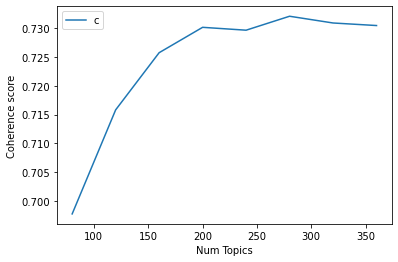

In [14]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=text_data, start=80, limit=400, step=40)
import matplotlib.pyplot as plt
# Show graph
limit=400; start=80; step=40;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [15]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(145, '0.268*"gate" + 0.070*"poor" + 0.042*"lost" + 0.028*"happening" + 0.028*"domestic" + 0.028*"deal" + 0.014*"lorena" + 0.014*"changed" + 0.014*"organization" + 0.014*"hacer"'), (147, '0.070*"appreciated" + 0.053*"giving" + 0.053*"plenty" + 0.035*"resolved" + 0.035*"confirmation" + 0.035*"stuck" + 0.035*"notice" + 0.035*"fee" + 0.035*"response" + 0.018*"military"'), (56, '0.231*"people" + 0.096*"delta" + 0.077*"broke" + 0.038*"date" + 0.038*"cheaper" + 0.019*"cheap" + 0.019*"terminal" + 0.019*"servicio" + 0.019*"goal" + 0.019*"deserves"'), (121, '0.185*"small" + 0.056*"night" + 0.056*"story" + 0.037*"turkey" + 0.037*"ride" + 0.037*"print" + 0.037*"link" + 0.037*"helpful" + 0.019*"clarify" + 0.019*"runway"'), (182, '0.130*"night" + 0.130*"member" + 0.072*"security" + 0.058*"checked" + 0.058*"nice" + 0.058*"compensation" + 0.043*"line" + 0.029*"awesome" + 0.029*"plastic" + 0.029*"frustrating"'), (176, '0.080*"ridiculous" + 0.080*"online" + 0.080*"lack" + 0.080*"made" + 0.040*"knowing

In [16]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=text_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.question.values.tolist())

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/tmp/ipykernel_17118/1405949489.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/tmp/ipykernel_17118/1405949489.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             152              0.0187   
1            1              20              0.0129   
2            2             123              0.0388   
3            3              61              0.0187   
4            4             108              0.0177   
5            5              73              0.0607   
6            6             183              0.0551   
7            7              49              0.0161   
8            8             105              0.0170   
9            9             148              0.0184   

                                            Keywords  \
0  flight, flying, bag, people, purchased, extra,...   
1  year, original, show, paid, long, feeling, fuc...   
2  airline, american, assisted, line, leonardo, l...   
3  boarding, pas, canceled, understand, aateam, u...   
4  home, great, love, cancelled, laptop, seat, fr...   
5  airline, wifi, joke, service, europe, asked, d...   
6  club, terminal, admiral, suck, arrived, overhe...   
7  hour, make, cancelled, blah, call, miss, hotel...   
8  check, booking, hold, work, airport, cancellin...   
9  flight, called, true, forgot, started, closed,...   

                                                Text  
0  @AmericanAir Erica on the lax team is amazing ...  
1  @AmericanAir Could you have someone on your la...  
2  Ben Tennyson and an American Airlines pilot. 🎃...  
3  @AmericanAir Right, but I earned those. I also...  
4  Thank you, @AmericanAir for playing #ThisIsUs ...  
5  @AmericanAir's wifi makes Amtrak's wifi look p...  
6  Wonderful club! @americanair (@ American Airli...  
7  @AmericanAir already did...changed browsers, d...  
8  @AmericanAir ........still....on....hold.....t...  
9  @AmericanAir well now i am told the ticket cos...

In [ ]:
userinput=preprocess("@AmericanAir Erica on the lax team is amazing give her a raise ty")
dictionaryInput = corpora.Dictionary([userinput])
corpusInput = [dictionary.doc2bow(userinput)]

df_topic_test = format_topics_sentences(ldamodel=optimal_model, corpus=corpusInput, texts="@AmericanAir Erica on the lax team is amazing give her a raise ty")

# Format
df_dominant_topic_test = df_topic_test.reset_index()
df_dominant_topic_test.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic_test.head()


In [ ]:
complete_df= df.join(df_dominant_topic, lsuffix='_database', rsuffix='_input')
complete_df.head()

In [ ]:
oui = complete_df[complete_df['Dominant_Topic']==168.0]
oui.head()

In [ ]:
oui.iloc[(oui['Topic_Perc_Contrib']-0.0207).abs().argsort()[:1]]


In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()